# Anomalies detection

In [55]:
%matplotlib inline 
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import IsolationForest
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
plt.style.use('fivethirtyeight')

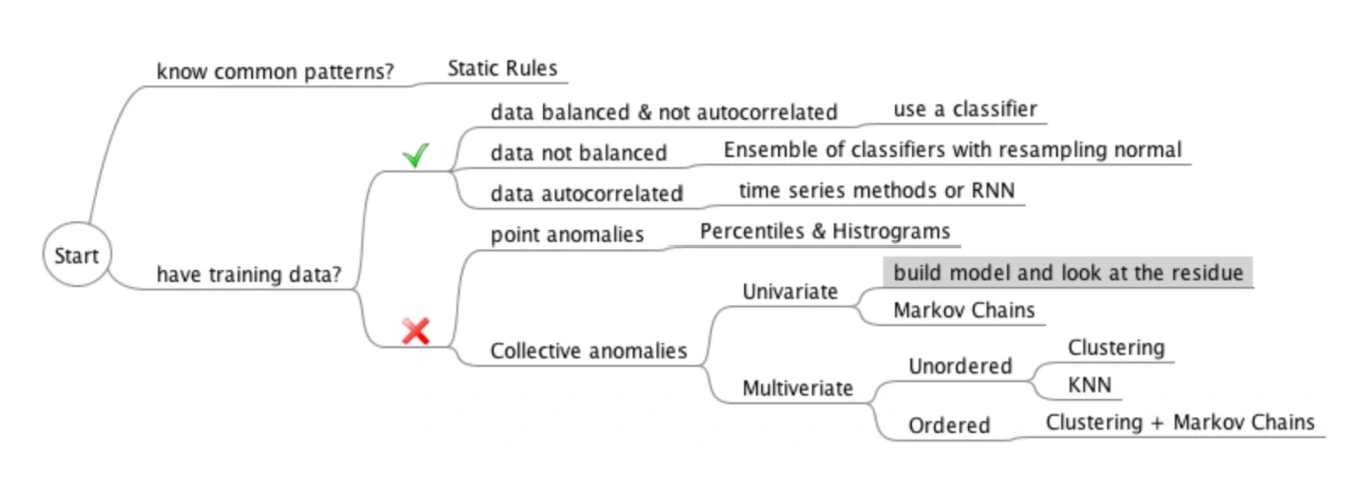

https://iwringer.wordpress.com/2015/11/17/anomaly-detection-concepts-and-techniques/

In [56]:
# get data frame
global_data = pd.read_csv('egc2024/timeseries/global.csv')
global_data

Unnamed: 0  year  month  day    total_fee  total_received_satoshi  \
0    2015-01-01  2015      1    1    801373971          45473028339385   
1    2015-01-02  2015      1    2   1159934218          73370568521080   
2    2015-01-03  2015      1    3   1196476043          82635189454578   
3    2015-01-04  2015      1    4   2159195328         115159442449532   
4    2015-01-05  2015      1    5   1608443040         112439228285641   
..          ...   ...    ...  ...          ...                     ...   
907  2017-06-26  2017      6   26  35993152232         375012739382430   
908  2017-06-27  2017      6   27  38384859820         287624055555912   
909  2017-06-28  2017      6   28  38663204682         282904720130478   
910  2017-06-29  2017      6   29  33153365173         317698686929569   
911  2017-06-30  2017      6   30  36690726272         333927062356198   

     total_sent_satoshi  mean_fee_satoshi   mean_feeUSD  mean_fee_for100  \
0        45058028339385      13609.829337  4.284054e+06         0.799999   
1        72955568521080      14978.682808  4.732406e+06         0.778933   
2        82220189454578      14304.385766  4.086009e+06         0.797419   
3       114726942449532      25138.199015  6.619757e+06         0.899054   
4       112051728285641      16955.609622  4.662858e+06         0.898594   
..                  ...               ...           ...              ...   
907     374842739382430     145080.443192  3.520181e+08         2.771988   
908     287452805555912     142346.452989  3.601857e+08         3.044288   
909     282717220130478     140744.451983  3.606988e+08         2.884102   
910     317543686929569     144453.442667  3.669758e+08         2.760877   
911     333740812356198     134084.908792  3.288717e+08         2.935174   

     nb_transactions  nb_payments  mean_nb_inputs  mean_nb_outputs  nb_mining  \
0              58882       161194        2.595241         2.737577        166   
1              77439       257633        2.715557         3.326915        166   
2              83644       295618        2.781885         3.534240        166   
3              85893       280288        2.770133         3.263223        173   
4              94862       286552        2.954471         3.020725        155   
..               ...          ...             ...              ...        ...   
907           248091       626222        2.565329         2.524163        136   
908           269658       747924        2.314862         2.773602        137   
909           274705       686018        2.471178         2.497290        150   
910           229509       570680        2.451838         2.486526        124   
911           273638       709817        2.498776         2.594000        149   

     total_mining_satoshi  newly_created_coins  self_spent_satoshi  \
0            415801373971         415000000000       2757774885900   
1            416159934218         415000000000       4316724676318   
2            416196476043         415000000000       5584584356557   
3            434659195328         432500000000       6554587956125   
4            389108443040         387500000000       5063695492444   
..                    ...                  ...                 ...   
907          205993152232         170000000000      14151200557043   
908          209634859820         171250000000      19821969138631   
909          226163204682         187500000000      10958737629631   
910          188153365173         155000000000      16909883109542   
911          222940726272         186250000000      19474802932200   

      total_received  volume_without_self  
0     45473028339385       42715253453485  
1     73370568521080       69053843844762  
2     82635189454578       77050605098021  
3    115159442449532      108604854493407  
4    112439228285641      107375532793197  
..               ...                  ...  
907  375012739382430      360861538825387  
908  287624055555912      26780208641

In [57]:
# removing unecessary data
global_data = global_data.drop(['year',	'month', 'day'], axis=1)
global_data = global_data.rename(columns={ global_data.columns[0]: "date" })
global_data['date'] = pd.to_datetime(global_data['date'])
global_data

date    total_fee  total_received_satoshi  total_sent_satoshi  \
0   2015-01-01    801373971          45473028339385      45058028339385   
1   2015-01-02   1159934218          73370568521080      72955568521080   
2   2015-01-03   1196476043          82635189454578      82220189454578   
3   2015-01-04   2159195328         115159442449532     114726942449532   
4   2015-01-05   1608443040         112439228285641     112051728285641   
..         ...          ...                     ...                 ...   
907 2017-06-26  35993152232         375012739382430     374842739382430   
908 2017-06-27  38384859820         287624055555912     287452805555912   
909 2017-06-28  38663204682         282904720130478     282717220130478   
910 2017-06-29  33153365173         317698686929569     317543686929569   
911 2017-06-30  36690726272         333927062356198     333740812356198   

     mean_fee_satoshi   mean_feeUSD  mean_fee_for100  nb_transactions  \
0        13609.829337  4.284054e+06         0.799999            58882   
1        14978.682808  4.732406e+06         0.778933            77439   
2        14304.385766  4.086009e+06         0.797419            83644   
3        25138.199015  6.619757e+06         0.899054            85893   
4        16955.609622  4.662858e+06         0.898594            94862   
..                ...           ...              ...              ...   
907     145080.443192  3.520181e+08         2.771988           248091   
908     142346.452989  3.601857e+08         3.044288           269658   
909     140744.451983  3.606988e+08         2.884102           274705   
910     144453.442667  3.669758e+08         2.760877           229509   
911     134084.908792  3.288717e+08         2.935174           273638   

     nb_payments  mean_nb_inputs  mean_nb_outputs  nb_mining  \
0         161194        2.595241         2.737577        166   
1         257633        2.715557         3.326915        166   
2         295618        2.781885         3.534240        166   
3         280288        2.770133         3.263223        173   
4         286552        2.954471         3.020725        155   
..           ...             ...              ...        ...   
907       626222        2.565329         2.524163        136   
908       747924        2.314862         2.773602        137   
909       686018        2.471178         2.497290        150   
910       570680        2.451838         2.486526        124   
911       709817        2.498776         2.594000        149   

     total_mining_satoshi  newly_created_coins  self_spent_satoshi  \
0            415801373971         415000000000       2757774885900   
1            416159934218         415000000000       4316724676318   
2            416196476043         415000000000       5584584356557   
3            434659195328         432500000000       6554587956125   
4            389108443040         387500000000       5063695492444   
..                    ...                  ...                 ...   
907          205993152232         170000000000      14151200557043   
908          209634859820         171250000000      19821969138631   
909          226163204682         187500000000      10958737629631   
910          188153365173         155000000000      16909883109542   
911          222940726272         186250000000      19474802932200   

      total_received  volume_without_self  
0     45473028339385       42715253453485  
1     73370568521080       69053843844762  
2     82635189454578       77050605098021  
3    115159442449532      108604854493407  
4    112439228285641      107375532793197  
..               ...                  ...  
907  375012739382430      360861538825387  
908  287624055555912      267802086417281  
909  282904720130478      271945982500847  
910  317698686929569      300788803820027  
911  333927062356198      314452259423998  

[912 rows x 17 columns]

In [58]:
# get the overview of our data
global_data.describe()

total_fee  total_received_satoshi  total_sent_satoshi  \
count  9.120000e+02            9.120000e+02        9.120000e+02   
mean   8.377424e+09            2.290891e+14        2.287877e+14   
std    1.035588e+10            2.791889e+14        2.791868e+14   
min    8.013740e+08            4.510624e+13        4.473624e+13   
25%    2.523110e+09            1.262725e+14        1.260853e+14   
50%    4.532365e+09            1.892992e+14        1.890190e+14   
75%    8.432361e+09            2.559993e+14        2.556574e+14   
max    6.590635e+10            6.368328e+15        6.367910e+15   

       mean_fee_satoshi   mean_feeUSD  mean_fee_for100  nb_transactions  \
count        912.000000  9.120000e+02       912.000000       912.000000   
mean       35139.905676  3.844541e+07         1.526634    197946.012061   
std        32525.188094  8.261346e+07         1.665052     72578.218717   
min        10461.599974  2.439673e+06         0.458950     58882.000000   
25%        17670.057766  5.030765e+06         0.904596    125391.000000   
50%        22773.512166  9.064531e+06         1.140273    208736.500000   
75%        33809.765909  2.350902e+07         1.594577    248158.250000   
max       197255.886201  5.339243e+08        24.526578    375231.000000   

        nb_payments  mean_nb_inputs  mean_nb_outputs   nb_mining  \
count  9.120000e+02      912.000000       912.000000  912.000000   
mean   5.379102e+05        2.593519         2.834069  149.918860   
std    1.891633e+05        0.386286         0.903461   13.904488   
min    1.611940e+05        1.958670         1.901898  110.000000   
25%    3.775470e+05        2.335038         2.489526  140.000000   
50%    5.505650e+05        2.548500         2.665185  149.000000   
75%    6.447005e+05        2.785754         2.857023  158.000000   
max    1.826440e+06        5.713032        12.707791  212.000000   

       total_mining_satoshi  newly_created_coins  self_spent_satoshi  \
count          9.120000e+02         9.120000e+02        9.120000e+02   
mean           3.097439e+11         3.013665e+11        1.379330e+13   
std            8.976175e+10         9.542954e+10        9.666815e+12   
min            1.501451e+11         1.437500e+11        1.567467e+12   
25%            2.097130e+11         1.925000e+11        8.031374e+12   
50%            3.453659e+11         3.425000e+11        1.147973e+13   
75%            3.826720e+11         3.800000e+11        1.674403e+13   
max            5.335712e+11         5.300000e+11        1.226605e+14   

       total_received  volume_without_self  
count    9.120000e+02         9.120000e+02  
mean     2.290891e+14         2.152958e+14  
std      2.791889e+14         2.780223e+14  
min      4.510624e+13         4.054264e+13  
25%      1.262725e+14         1.149386e+14  
50%      1.892992e+14         1.753236e+14  
75%      2.559993e+14         2.401501e+14  
max      6.368328e+15         6.360983e+15

On remarque que les caracteristiques de total_received_satoshi et de total_sent_satoshi sont un peu differentes. On peut se poser la question ou sont passe les satoshi manquants.

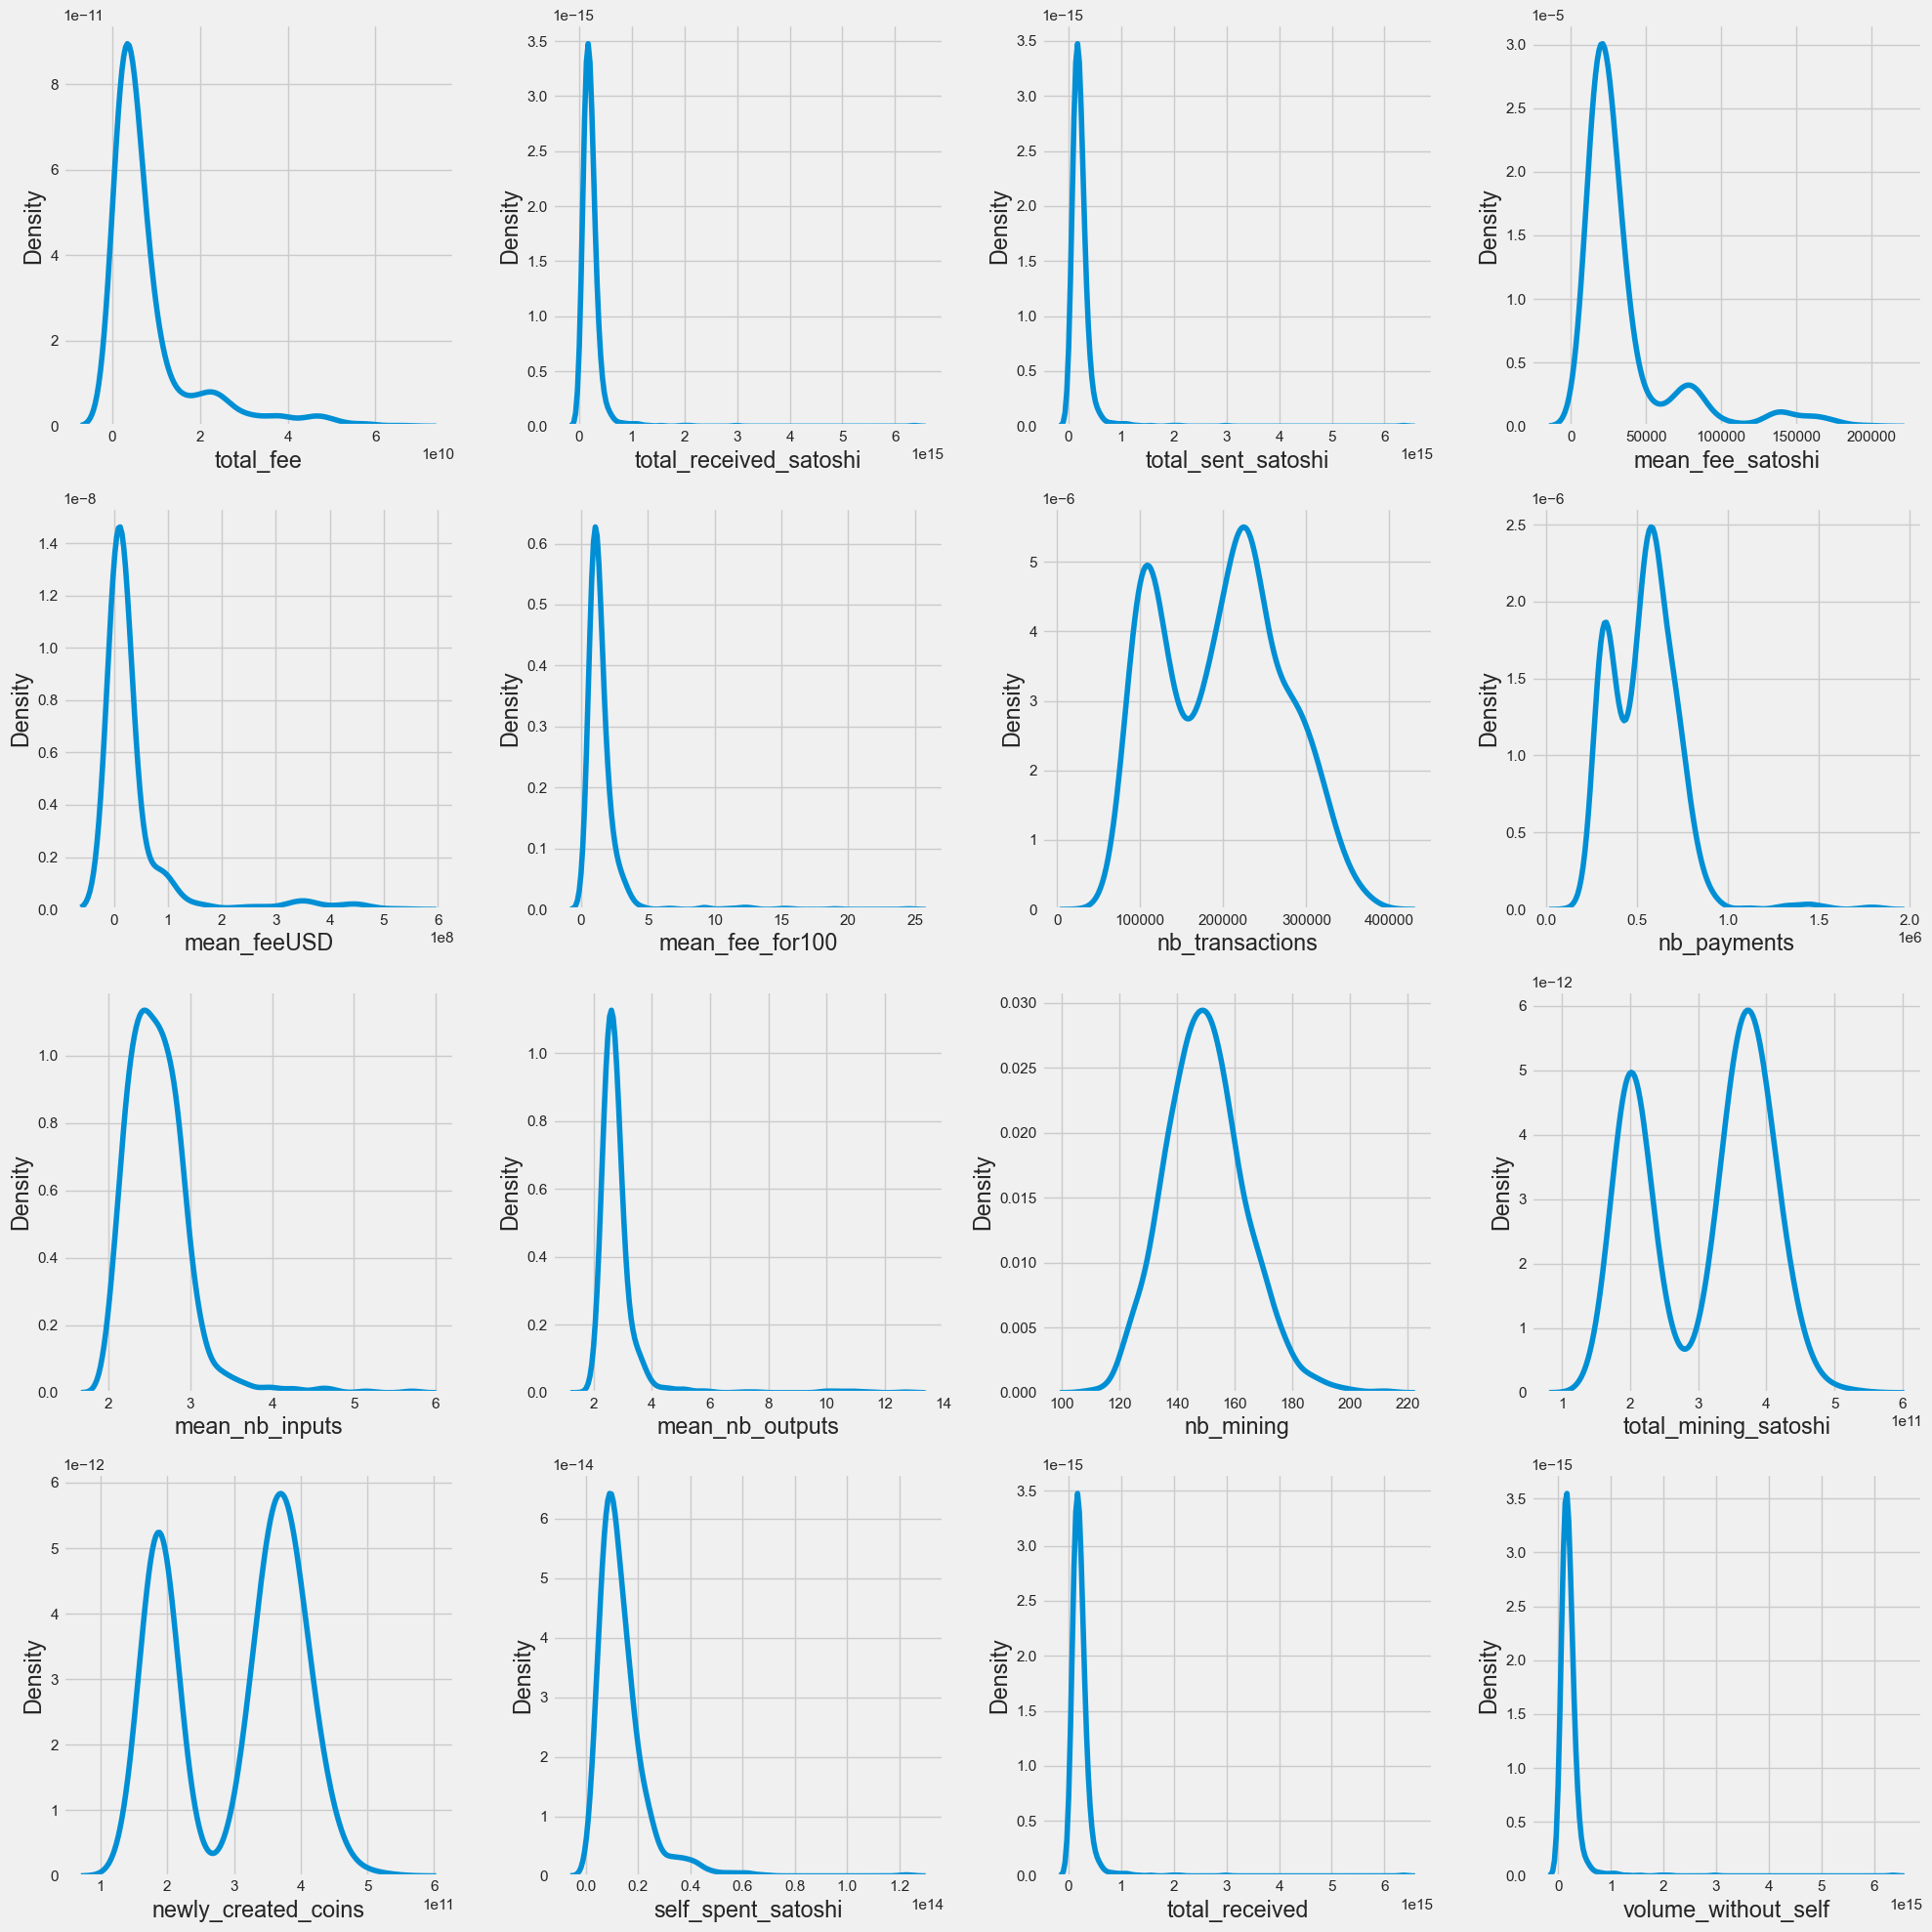

In [75]:
parameters = ['total_fee', 'total_received_satoshi', 'total_sent_satoshi', 'mean_fee_satoshi', 'mean_feeUSD', 'mean_fee_for100', 'nb_transactions',	'nb_payments', 'mean_nb_inputs', 'mean_nb_outputs', 'nb_mining', 'total_mining_satoshi', 'newly_created_coins',	'self_spent_satoshi', 'total_received', 'volume_without_self']

plt.rcParams["figure.figsize"] = [20, 20]
plt.rcParams["figure.autolayout"] = True
fig, ax = plt.subplots(4,4)
i = 0
for x in range(4):
    for y in range(4):
        sns.kdeplot(global_data[parameters[i]], ax=ax[x][y])
        i += 1


<Axes: xlabel='total_mining_satoshi', ylabel='Density'>

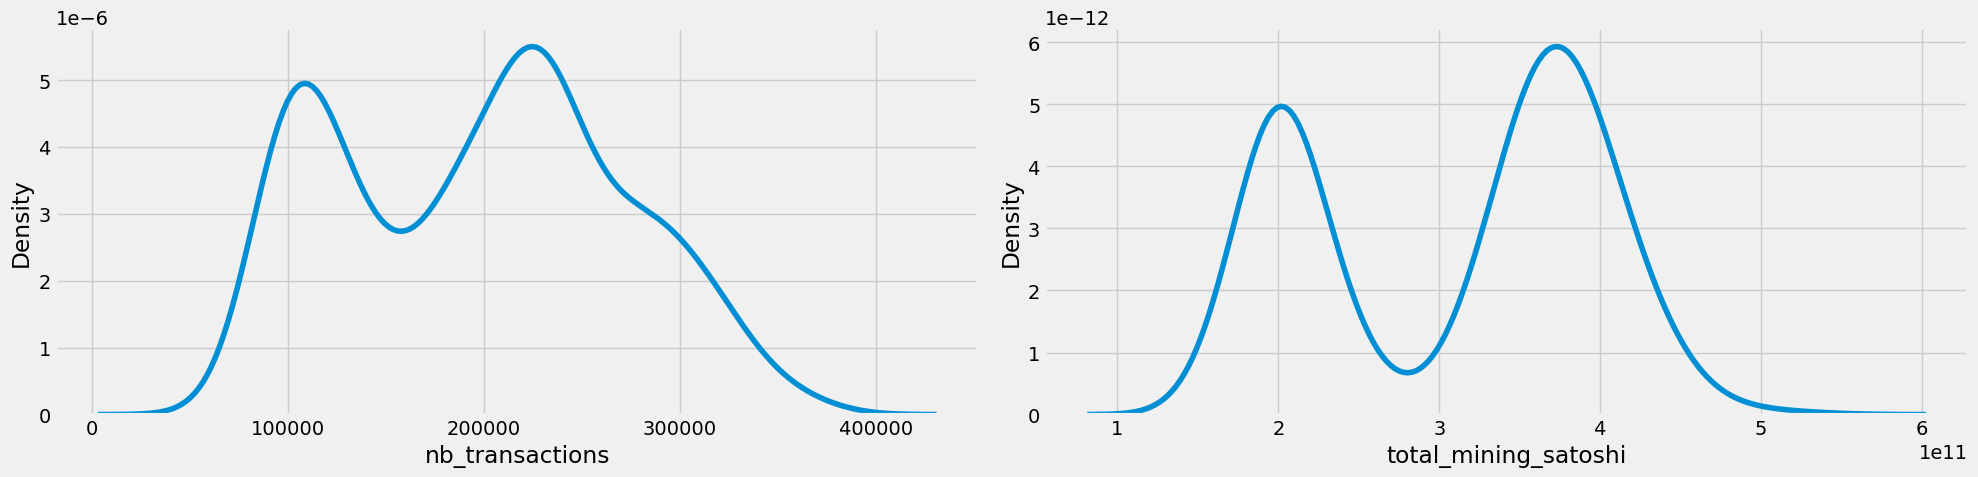

In [5]:
plt.rcParams["figure.figsize"] = [20, 5]
plt.rcParams["figure.autolayout"] = True
fig, ax = plt.subplots(1,2)
sns.kdeplot(global_data['nb_transactions'], ax=ax[0])
sns.kdeplot(global_data['total_mining_satoshi'], ax=ax[1])

Text(0.5, 1.0, 'Transactions per day')

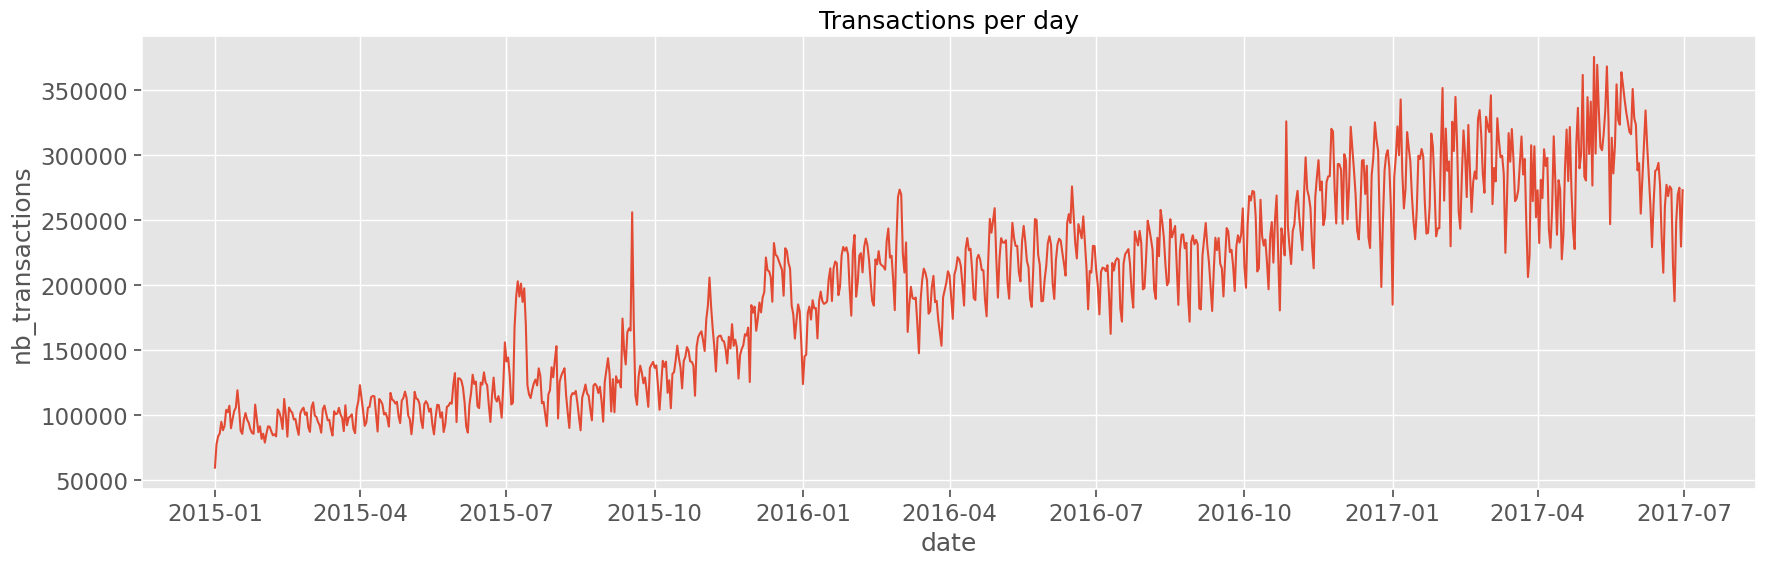

In [6]:
plt.style.use('ggplot')
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 1.5})

g = plt.subplots(figsize=(18, 6))
g = sns.lineplot(x='date', y='nb_transactions', data=global_data)
plt.title('Transactions per day')

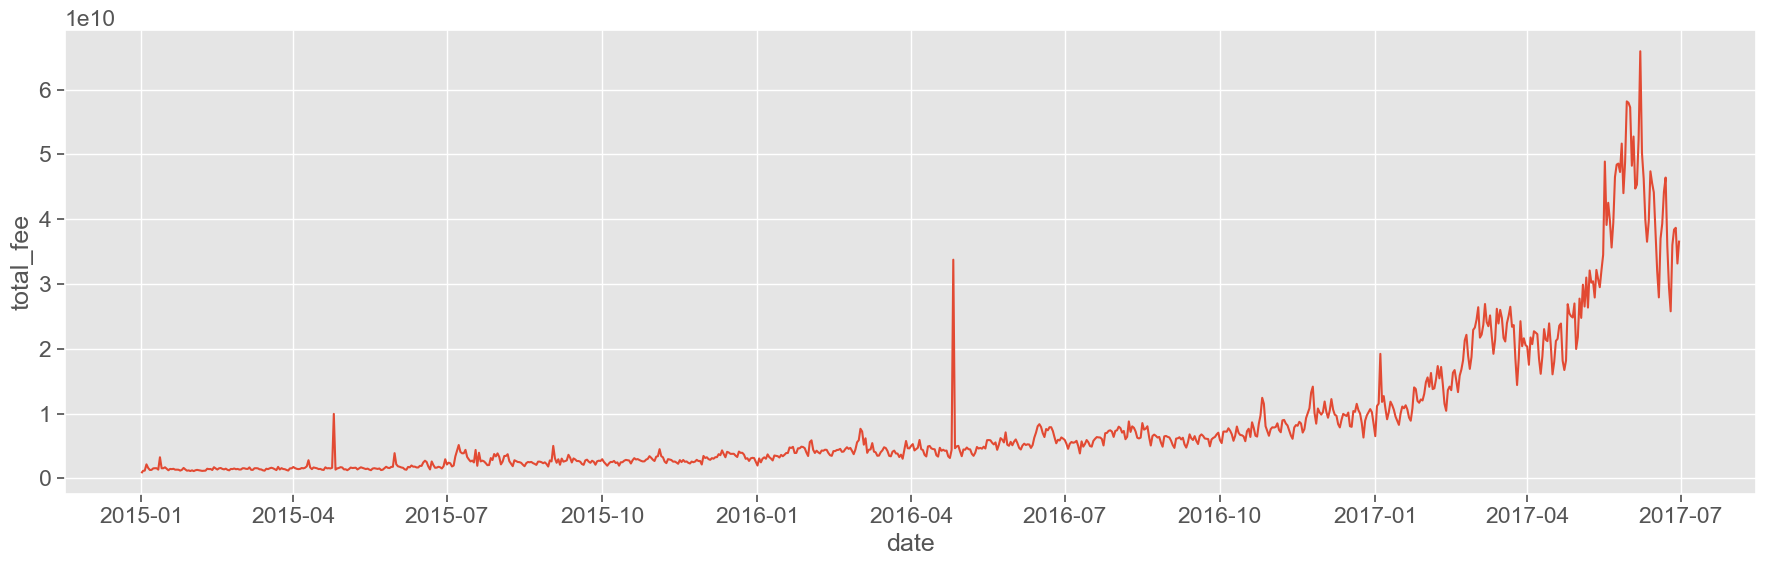

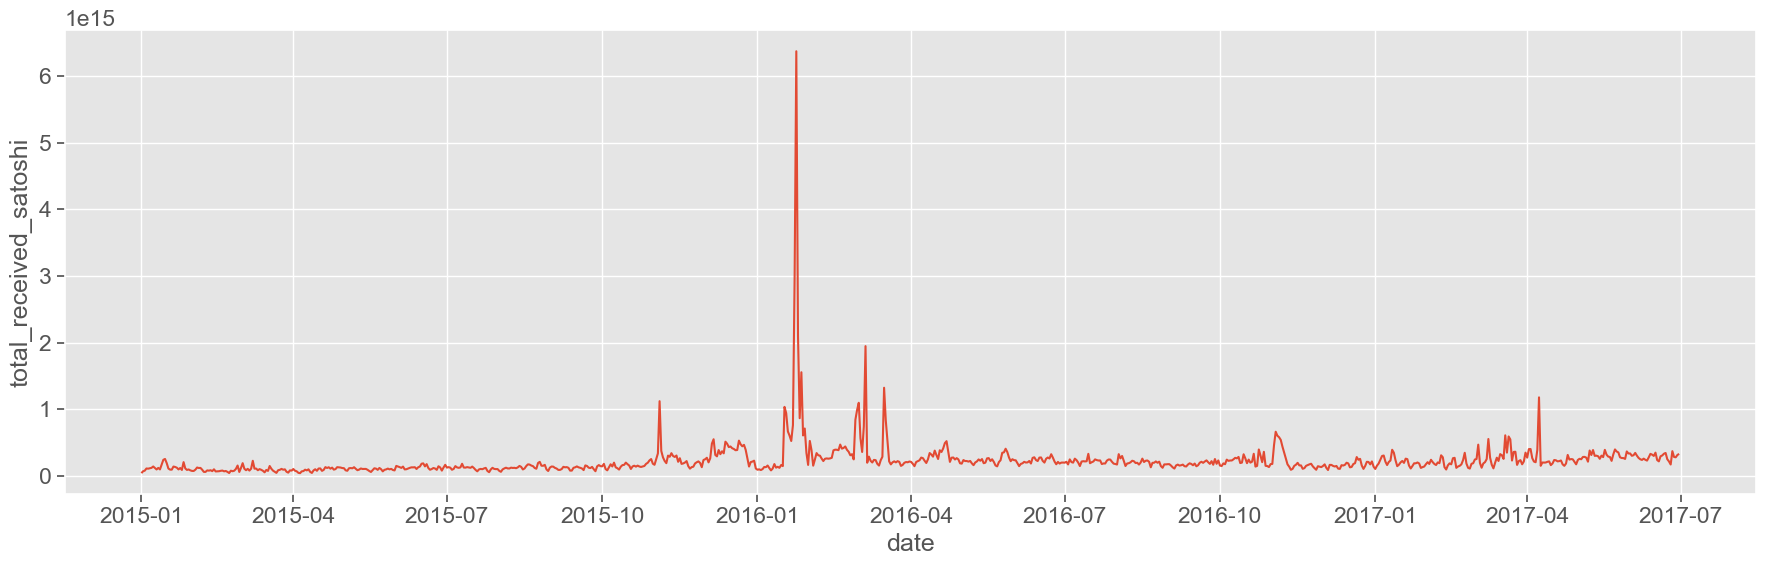

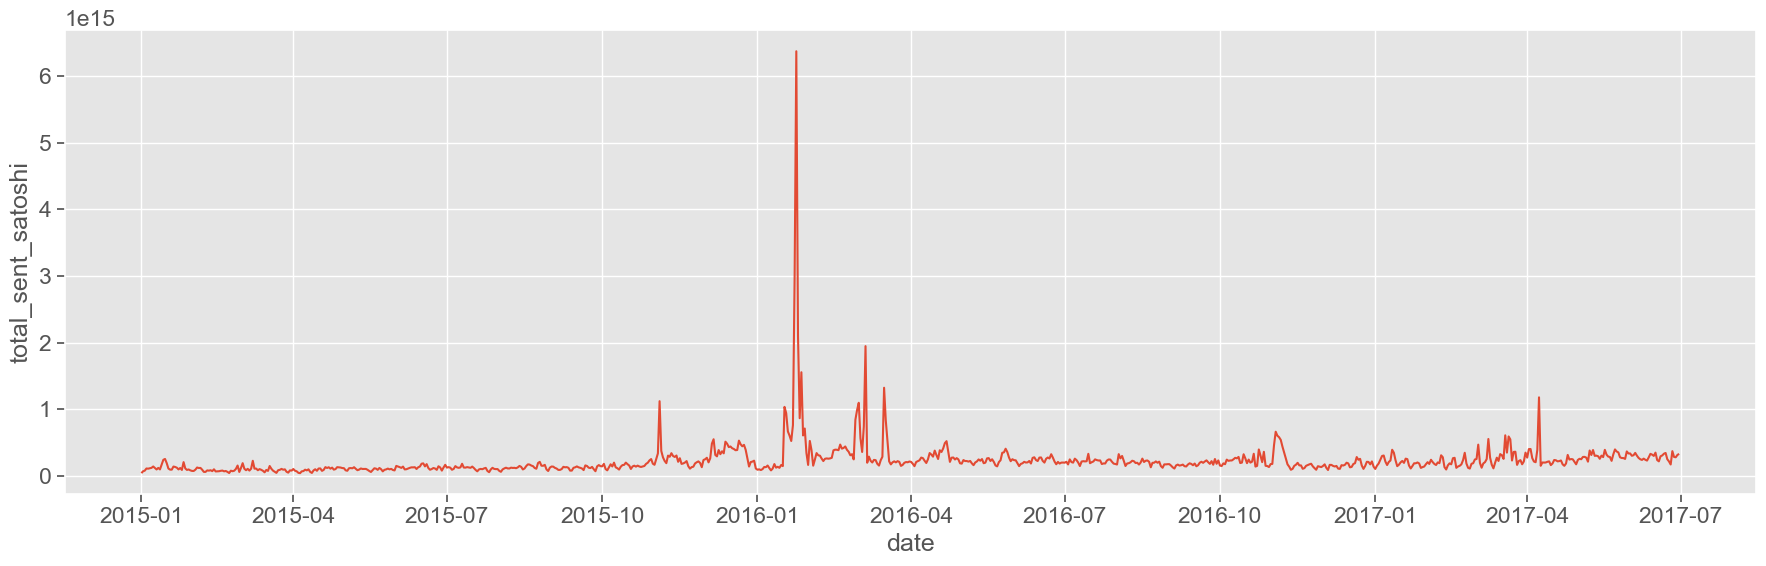

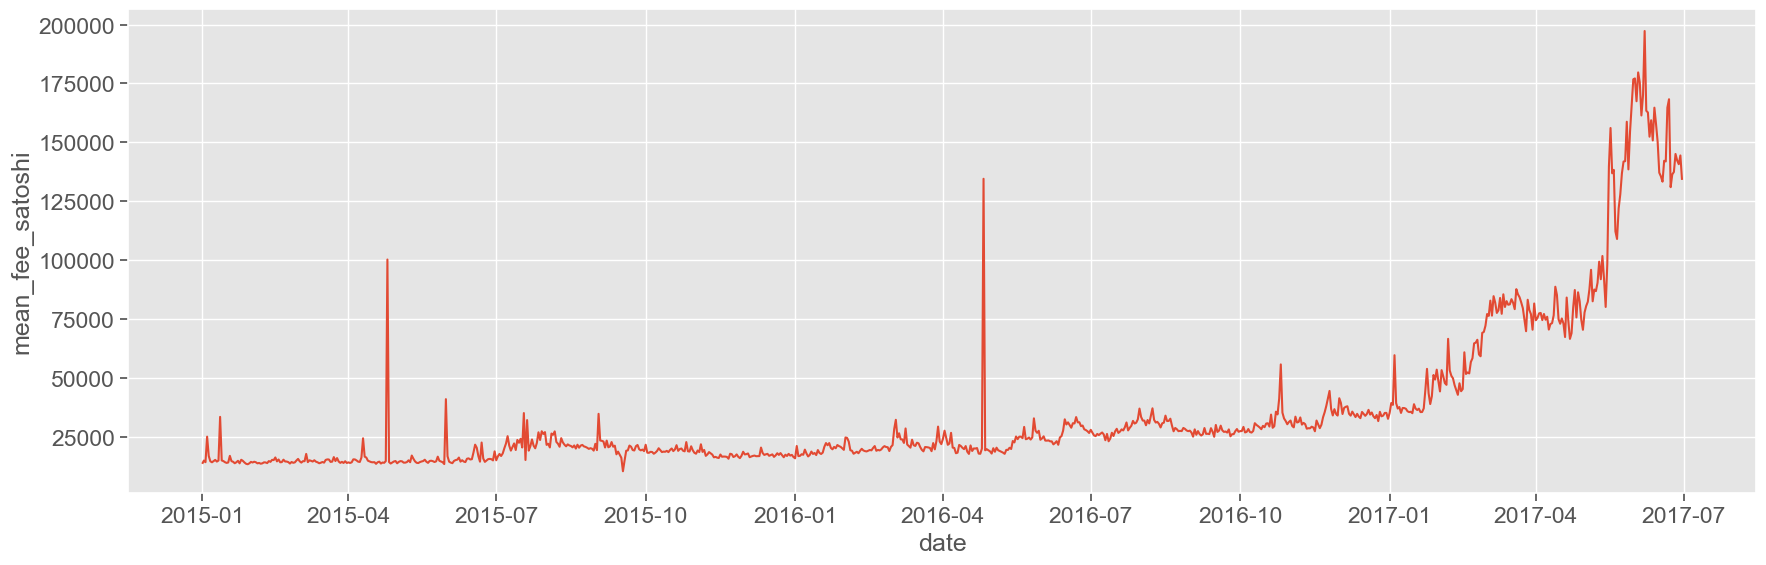

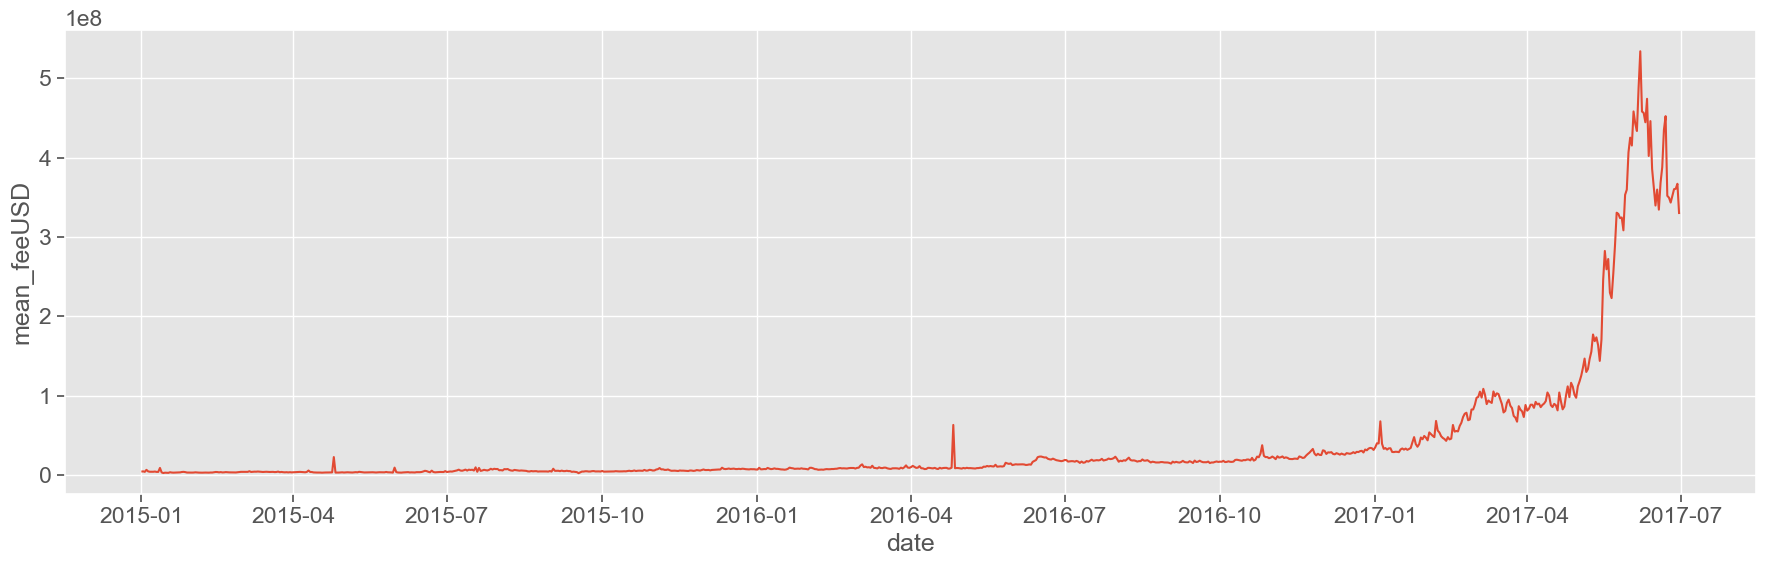

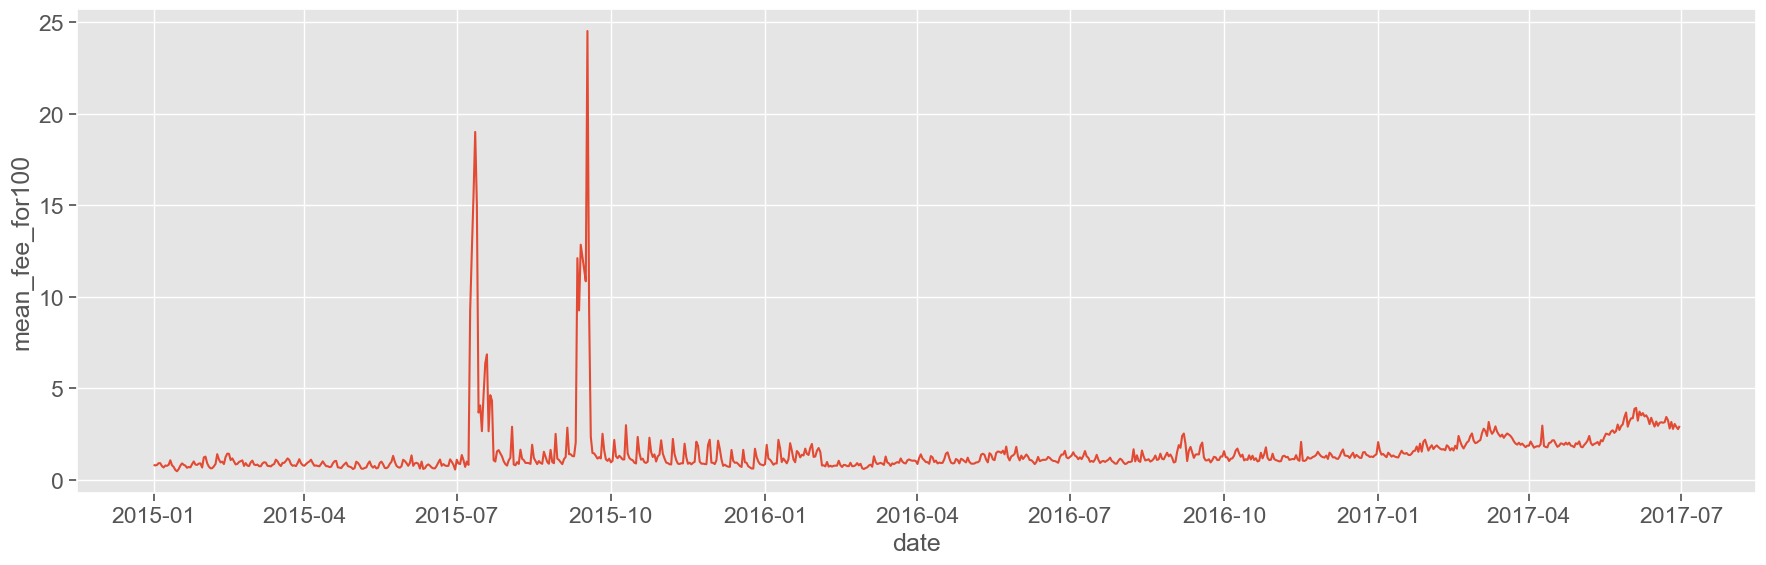

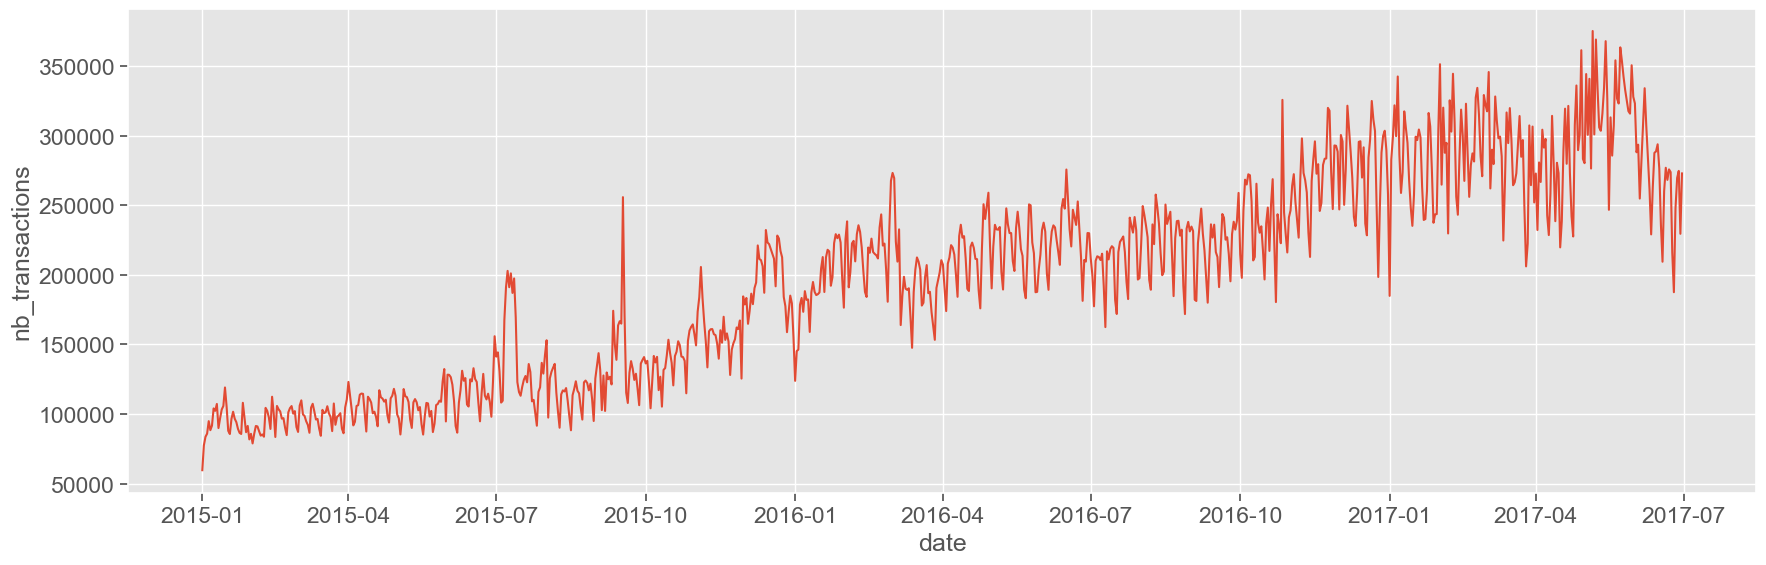

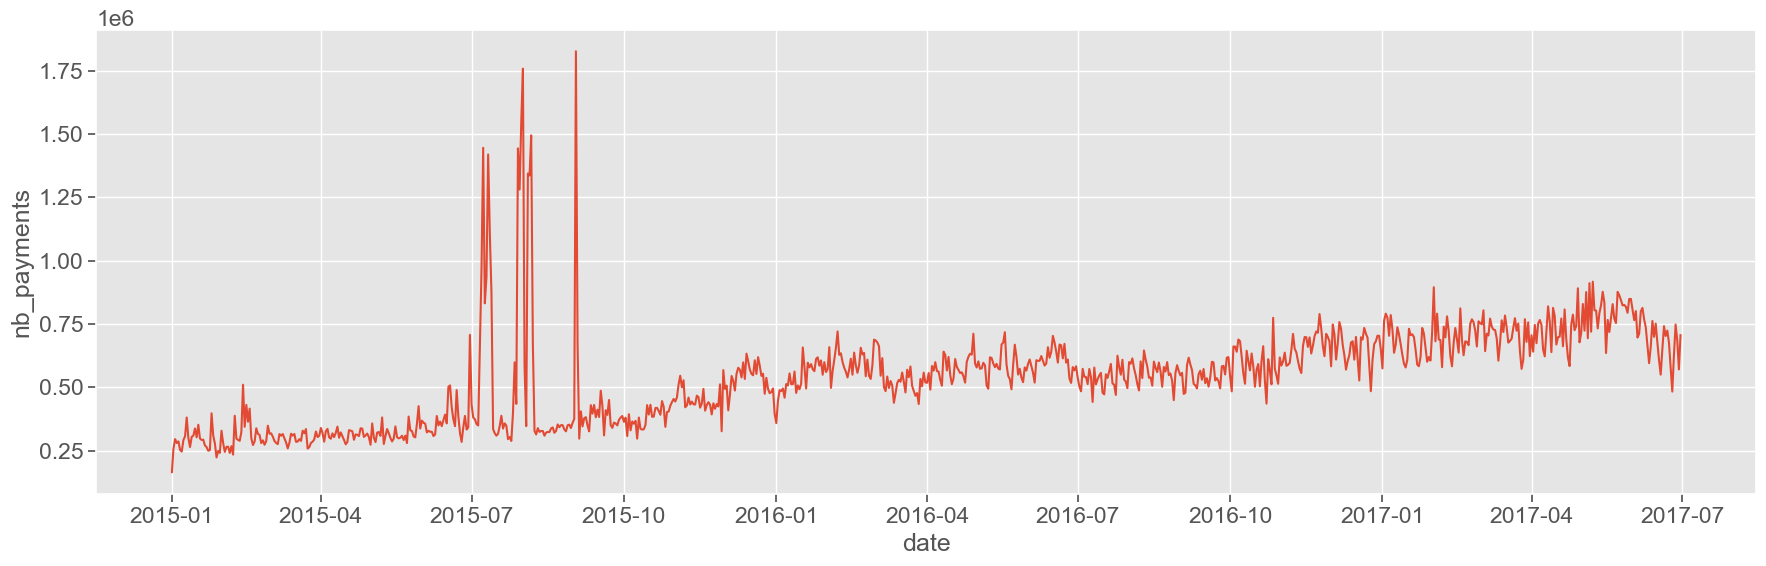

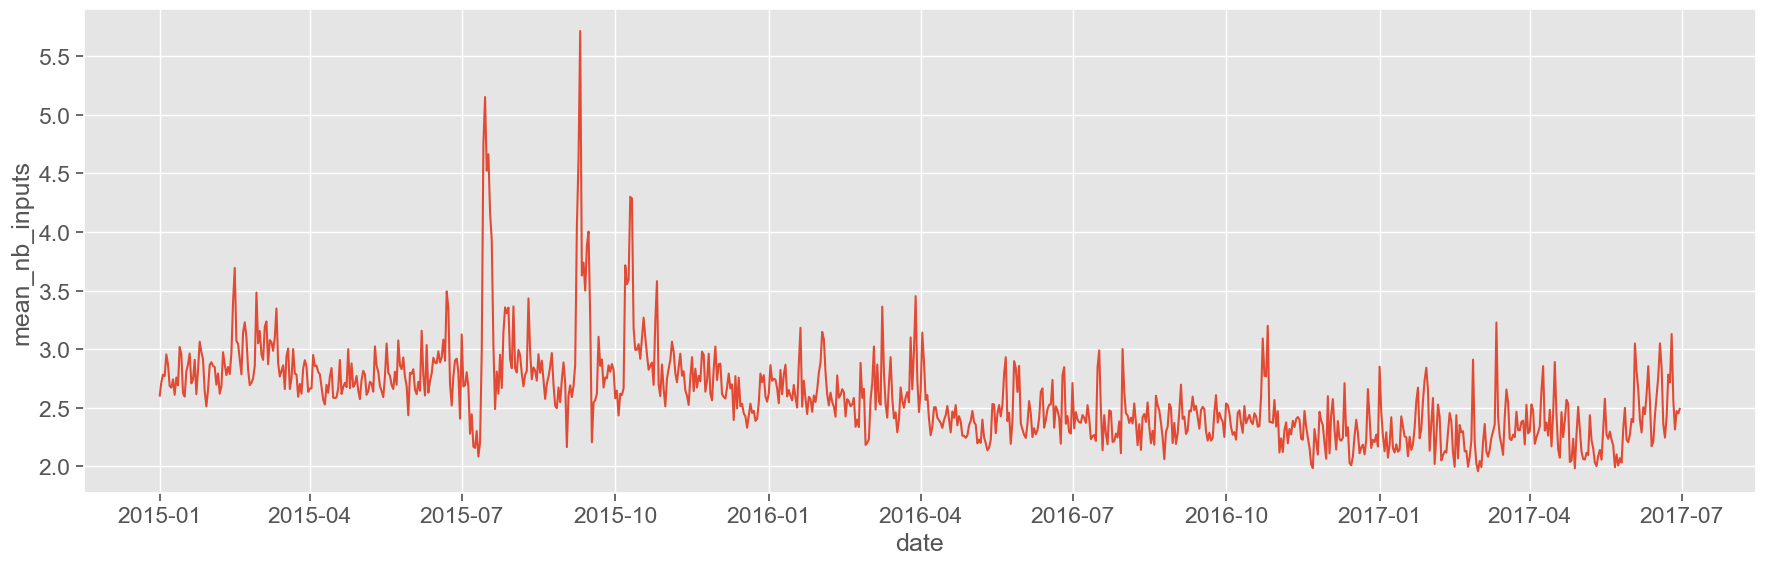

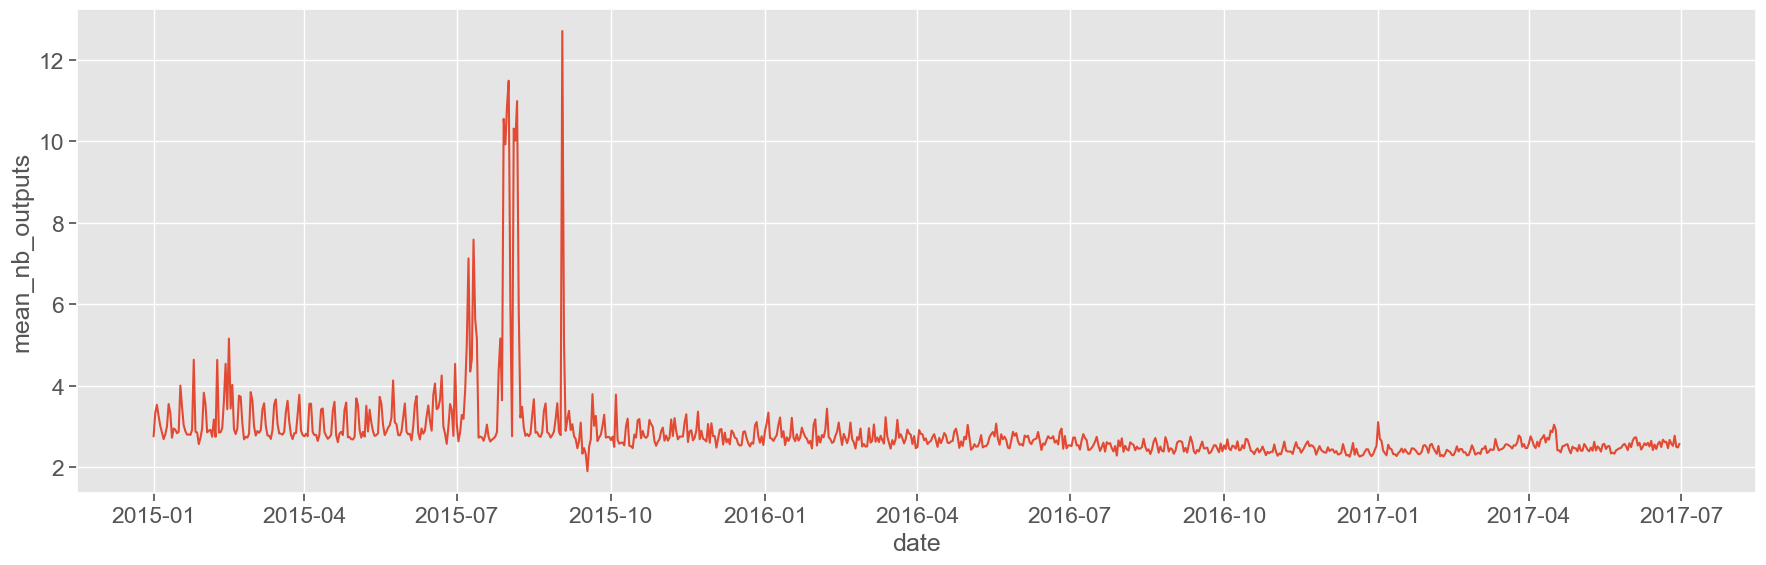

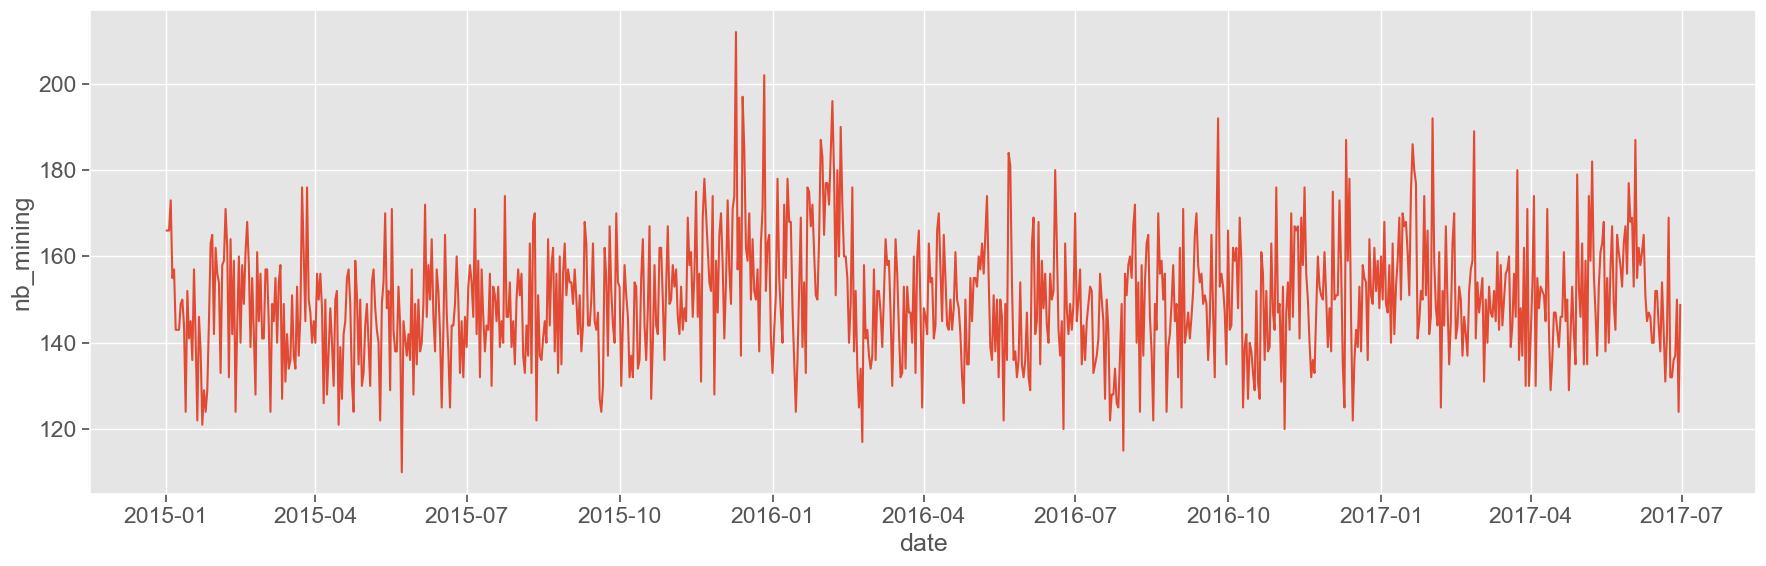

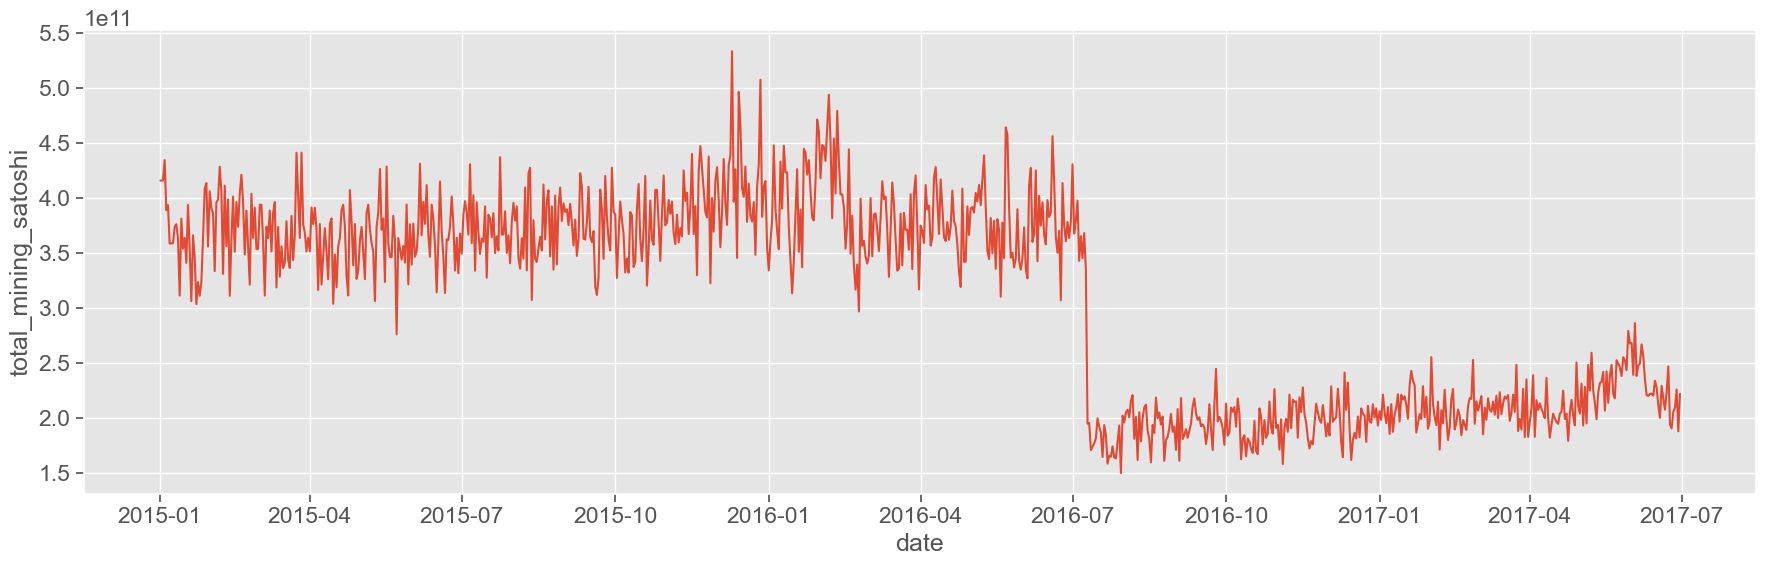

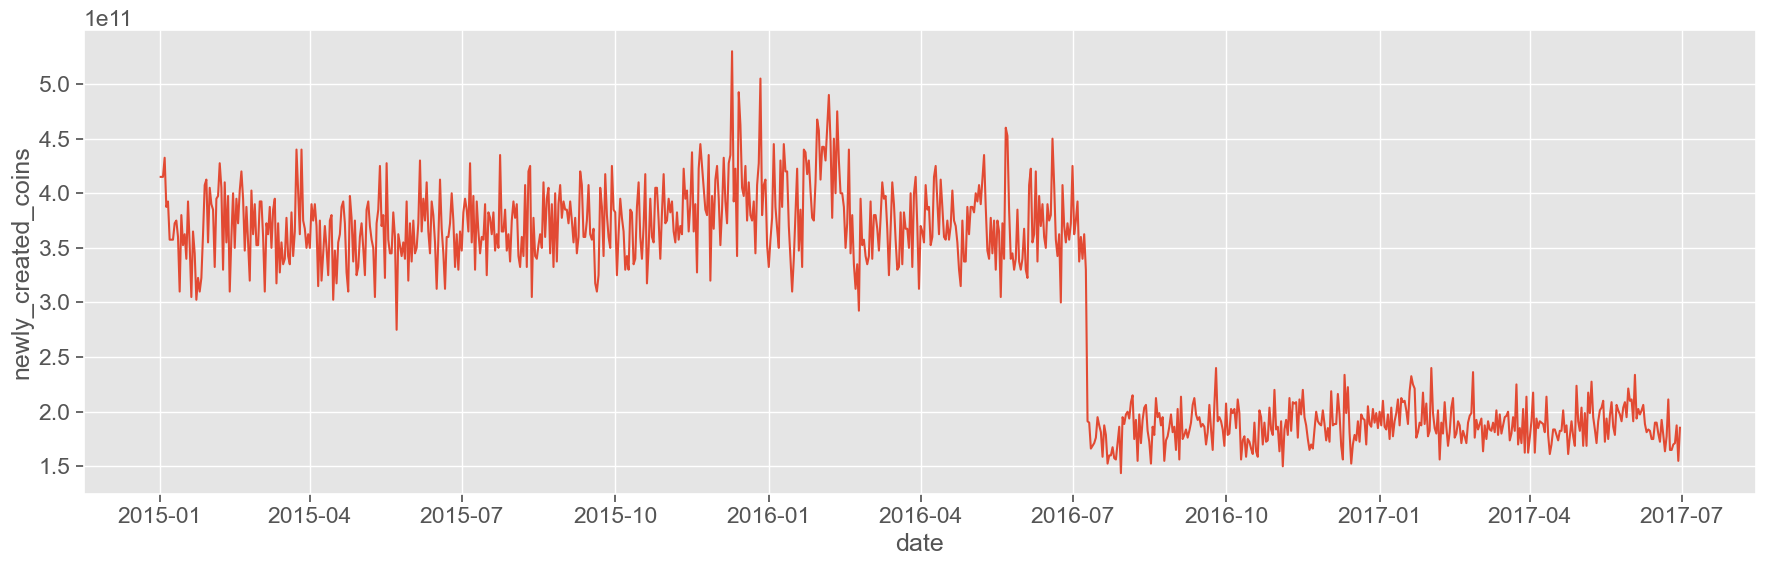

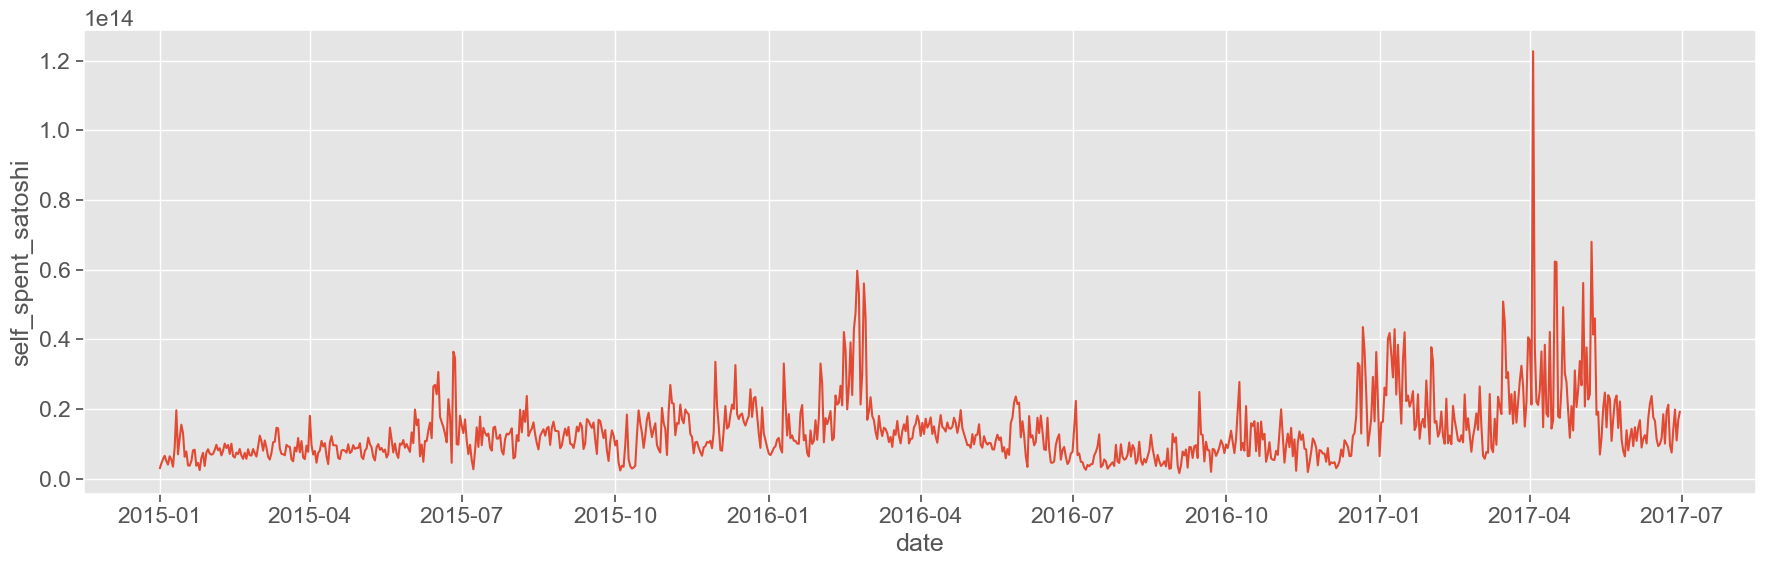

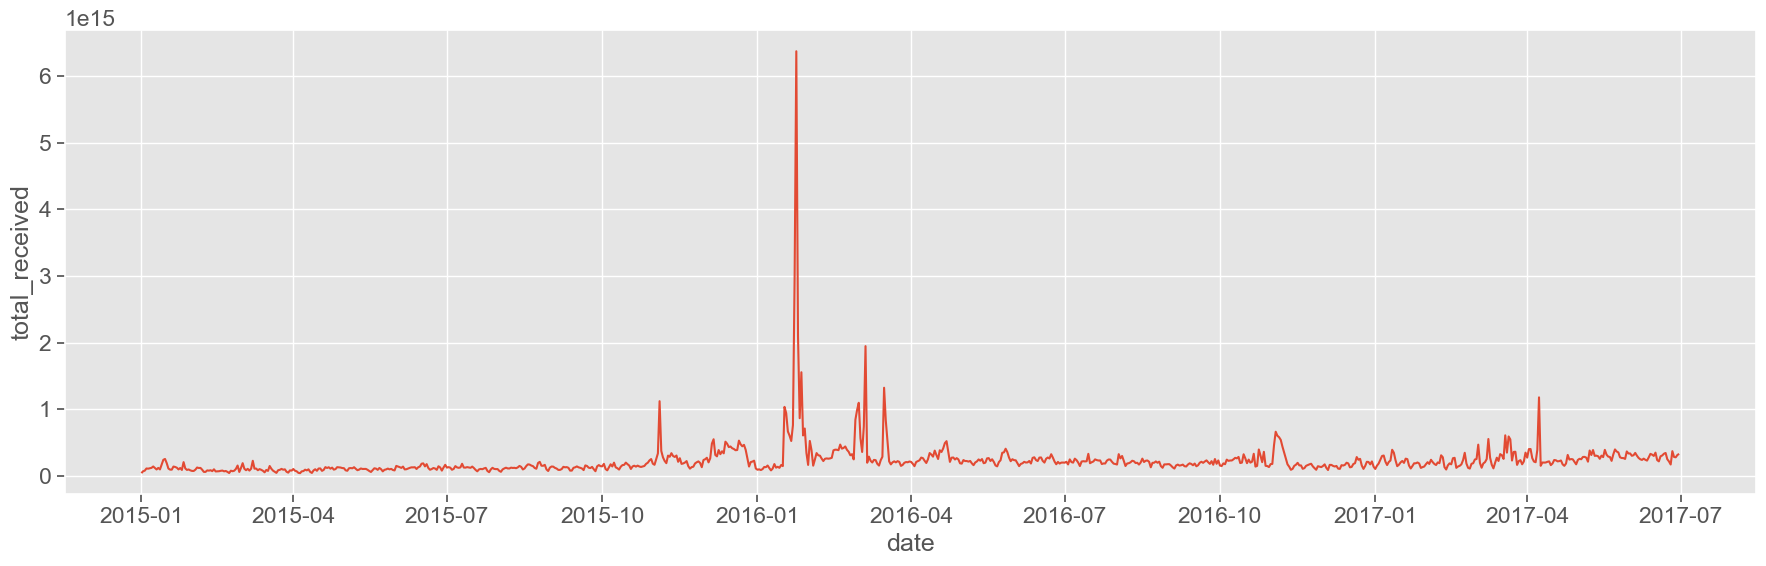

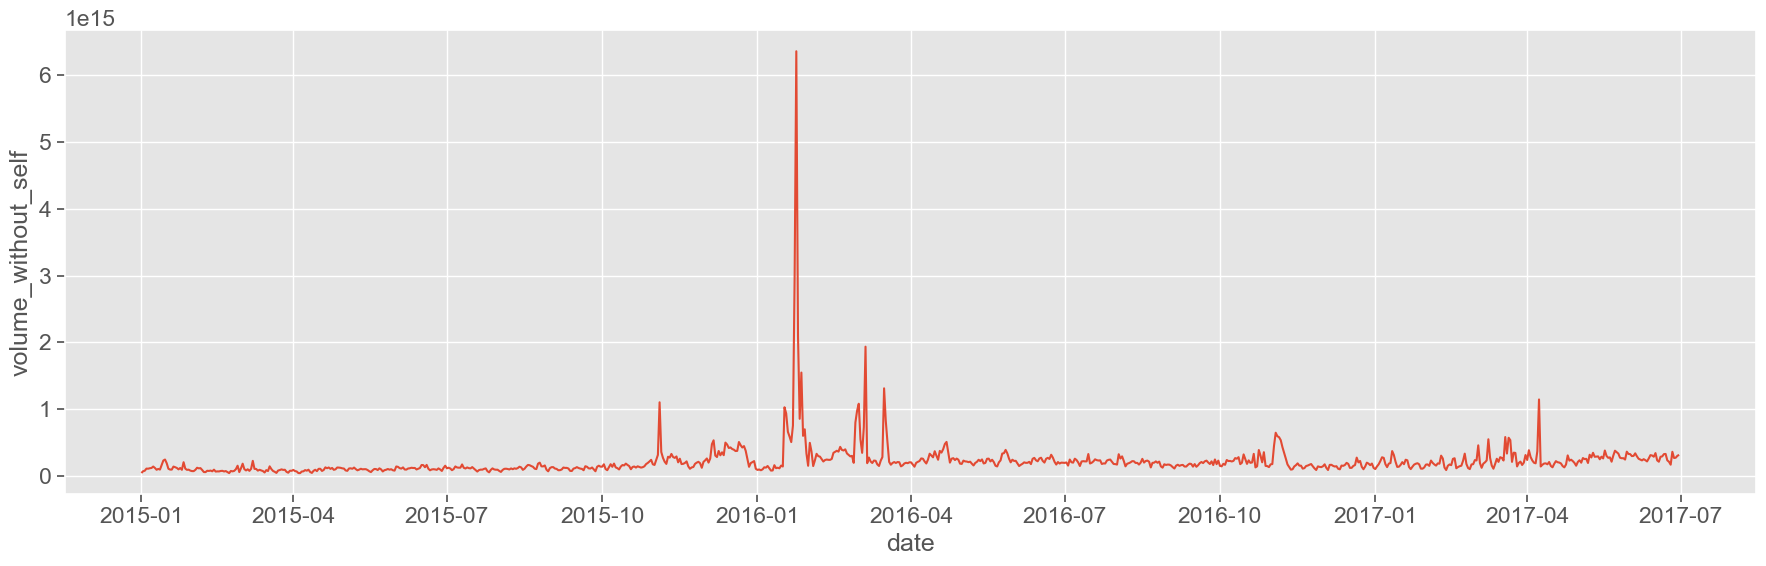

In [76]:
plt.style.use('ggplot')
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 1.5})

for i in range(len(parameters)):
    g = plt.subplots(figsize=(18, 6))
    g = sns.lineplot(x='date', y=parameters[i], data=global_data)

Text(0.5, 1.0, 'Transactions per day')

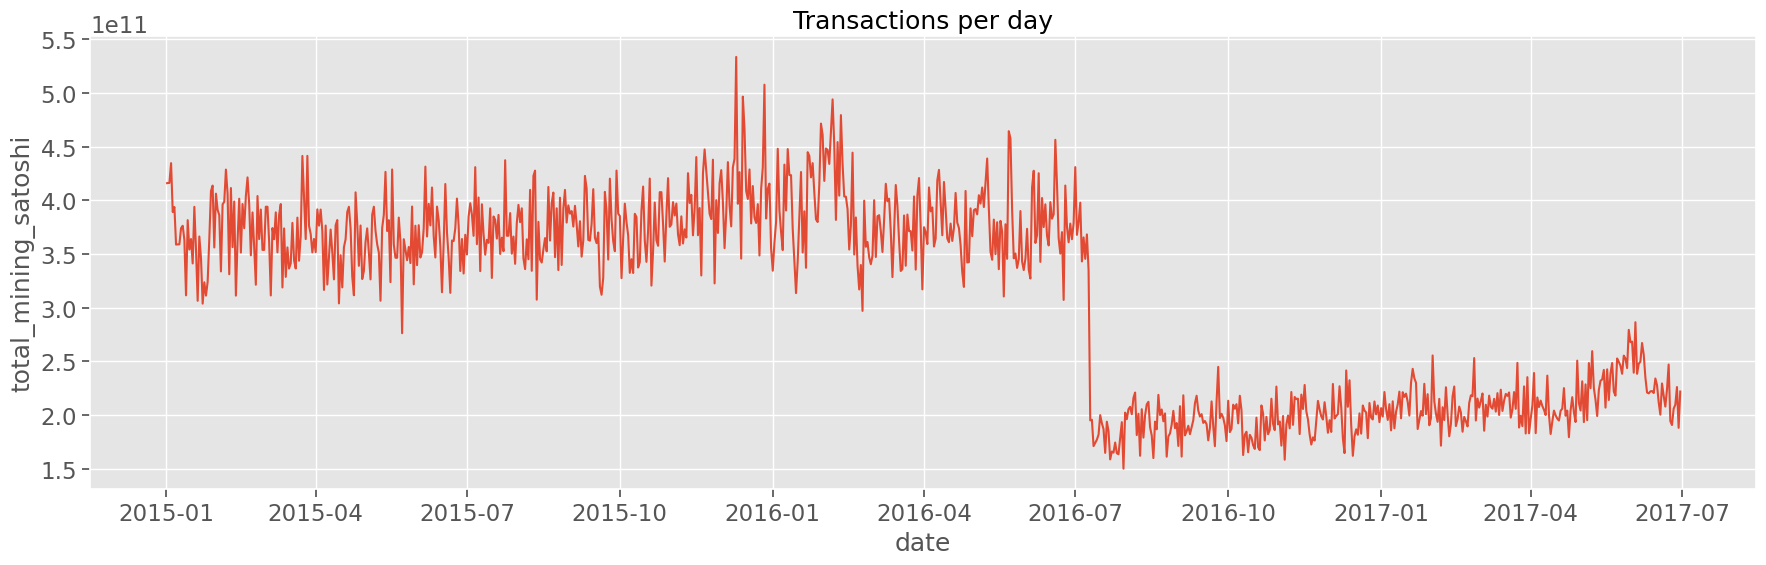

In [7]:
plt.style.use('ggplot')
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 1.5})

g = plt.subplots(figsize=(18, 6))
g = sns.lineplot(x='date', y='total_mining_satoshi', data=global_data)
plt.title('Transactions per day')

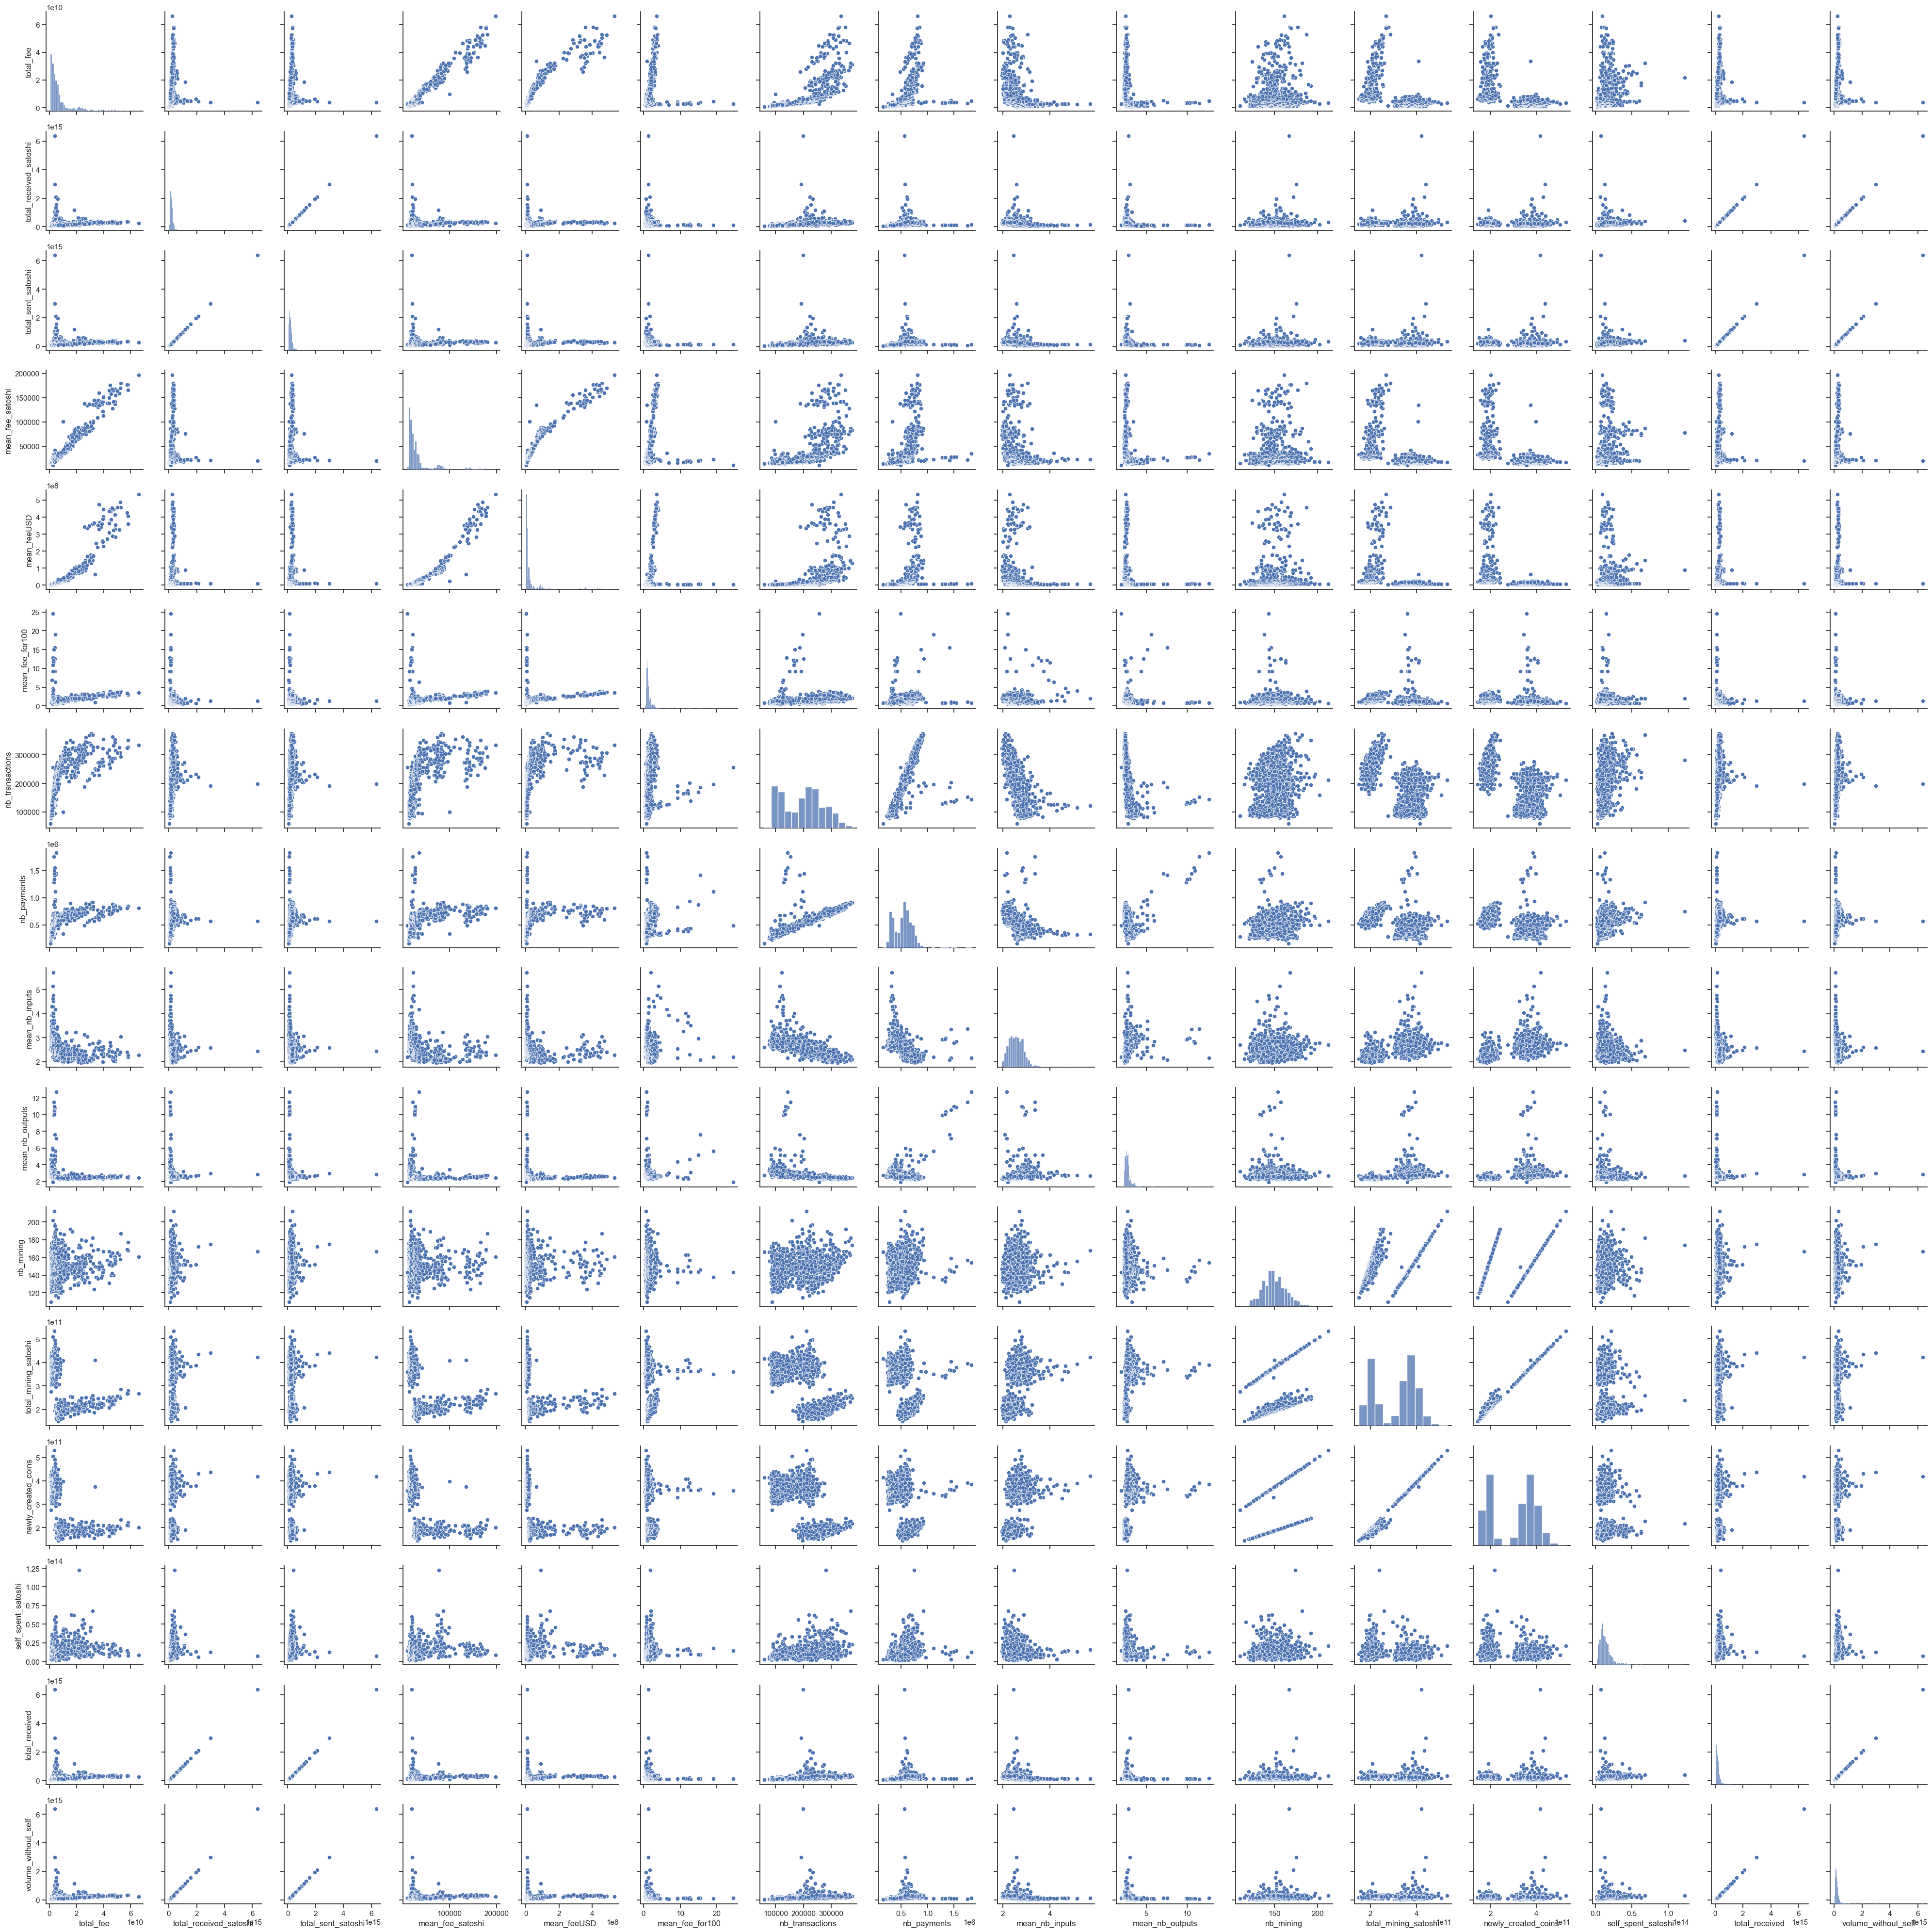

In [77]:
# check the relation among the features of data
sns.set(style="ticks")
sns.pairplot(global_data)

Isolation Forests is a ML algorithm based on decision trees. And since there are no pre-defined labels here, it is an unsupervised model. IsolationForests were built based on the fact that anomalies are the data points that are "few and different". 

Algorithm :
1. When given a dataset, a random sub-sample of the data is selected and assigned to a binary tree.
2. Branching of the tree starts by selecting a random feature (from the set of all N features) first. And then branching is done on a random threshold (any value in the range of minimum and maximum values of the selected feature).
3. If the value of a data point is less than the selected threshold, it goes to the left branch else to the right. And thus a node is split into left and right branches.
4. This process from step 2 is continued recursively till each data point is completely isolated or till max depth (if defined) is reached.
5. The above steps are repeated to construct random binary trees
6. After an ensemble of isolation trees is created, model training is complete. During scoring, a data point is traversed through all the trees which were trained earlier. Now, an "anomaly score" is assigned to each of the data points based on the depth of the tree required to arrive at that point. This score is an aggregation of the depth obtained from each of the trees. An anomaly score of -1 is assigned to anomalies and 1 to normal points based on the contamination (percentage of anomalies present in the data) parameter provided.

In [78]:
# select the three most important features (Transactions, Blocks, Output Satoshis) from the data
data = global_data[['mean_nb_outputs','mean_nb_inputs']]
outliers_fraction=0.05
scaler = StandardScaler()
np_scaled = scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)

# train isolation forest
model = IsolationForest(contamination=outliers_fraction)
model.fit(data)

IsolationForest(contamination=0.05)

In [9]:
# select the three most important features (Transactions, Blocks, Output Satoshis) from the data
data = global_data[['total_mining_satoshi','nb_transactions']]
outliers_fraction=0.05
scaler = StandardScaler()
np_scaled = scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)

# train isolation forest
model = IsolationForest(contamination=outliers_fraction)
model.fit(data)

IsolationForest(contamination=0.05)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 0.92, 'Transactions vs Satoshis: Red represents Anomalies')

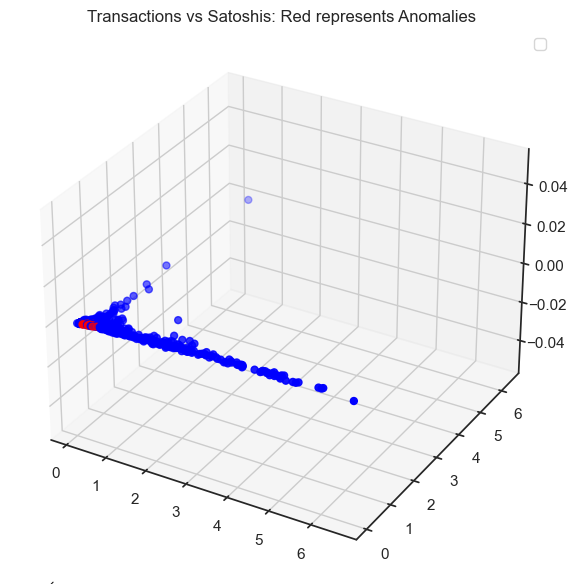

In [79]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111,projection='3d')
X = global_data.iloc[:,1:3].values
colors = np.array(['red', 'blue'])
y_pred = model.fit_predict(data)
ax.scatter(X[:, 0], X[:, 1], s=25, color=colors[(y_pred + 1) // 2] )
ax.legend()
#plt.xlabel('Transactions')
#plt.ylabel('Blocks')
#plt.zlabel('Sum of Output Satoshis')
plt.title('Transactions vs Satoshis: Red represents Anomalies')



In [80]:
# create a new column for storing the results of Isolation Forest method
global_data['anomaly_IsolationForest'] = pd.Series(model.predict(data))
global_data['anomaly_IsolationForest'] = global_data['anomaly_IsolationForest'].apply(lambda x: x == -1)
global_data['anomaly_IsolationForest'] = global_data['anomaly_IsolationForest'].astype(int)
global_data['anomaly_IsolationForest'].value_counts()

0    866
1     46
Name: anomaly_IsolationForest, dtype: int64

In [81]:
global_data

date    total_fee  total_received_satoshi  total_sent_satoshi  \
0   2015-01-01    801373971          45473028339385      45058028339385   
1   2015-01-02   1159934218          73370568521080      72955568521080   
2   2015-01-03   1196476043          82635189454578      82220189454578   
3   2015-01-04   2159195328         115159442449532     114726942449532   
4   2015-01-05   1608443040         112439228285641     112051728285641   
..         ...          ...                     ...                 ...   
907 2017-06-26  35993152232         375012739382430     374842739382430   
908 2017-06-27  38384859820         287624055555912     287452805555912   
909 2017-06-28  38663204682         282904720130478     282717220130478   
910 2017-06-29  33153365173         317698686929569     317543686929569   
911 2017-06-30  36690726272         333927062356198     333740812356198   

     mean_fee_satoshi   mean_feeUSD  mean_fee_for100  nb_transactions  \
0        13609.829337  4.284054e+06         0.799999            58882   
1        14978.682808  4.732406e+06         0.778933            77439   
2        14304.385766  4.086009e+06         0.797419            83644   
3        25138.199015  6.619757e+06         0.899054            85893   
4        16955.609622  4.662858e+06         0.898594            94862   
..                ...           ...              ...              ...   
907     145080.443192  3.520181e+08         2.771988           248091   
908     142346.452989  3.601857e+08         3.044288           269658   
909     140744.451983  3.606988e+08         2.884102           274705   
910     144453.442667  3.669758e+08         2.760877           229509   
911     134084.908792  3.288717e+08         2.935174           273638   

     nb_payments  mean_nb_inputs  mean_nb_outputs  nb_mining  \
0         161194        2.595241         2.737577        166   
1         257633        2.715557         3.326915        166   
2         295618        2.781885         3.534240        166   
3         280288        2.770133         3.263223        173   
4         286552        2.954471         3.020725        155   
..           ...             ...              ...        ...   
907       626222        2.565329         2.524163        136   
908       747924        2.314862         2.773602        137   
909       686018        2.471178         2.497290        150   
910       570680        2.451838         2.486526        124   
911       709817        2.498776         2.594000        149   

     total_mining_satoshi  newly_created_coins  self_spent_satoshi  \
0            415801373971         415000000000       2757774885900   
1            416159934218         415000000000       4316724676318   
2            416196476043         415000000000       5584584356557   
3            434659195328         432500000000       6554587956125   
4            389108443040         387500000000       5063695492444   
..                    ...                  ...                 ...   
907          205993152232         170000000000      14151200557043   
908          209634859820         171250000000      19821969138631   
909          226163204682         187500000000      10958737629631   
910          188153365173         155000000000      16909883109542   
911          222940726272         186250000000      19474802932200   

      total_received  volume_without_self  anomaly_IsolationForest  
0     45473028339385       42715253453485                        0  
1     73370568521080       69053843844762                        0  
2     82635189454578       77050605098021                        0  
3    115159442449532      108604854493407                        0  
4    112439228285641      107375532793197                        0  
..               ...                  ...                      ...  
907  375012739382430      360861538825387                        0  
908  287624055555912      267802086417281                        0  
9

In [82]:

a = global_data.loc[global_data['anomaly_IsolationForest'] == 1]
a

date   total_fee  total_received_satoshi  total_sent_satoshi  \
24  2015-01-25  1313613049          93088609618332      92778609618332   
44  2015-02-14  1527536330          71105282772002      70705282772002   
45  2015-02-15  1361600276          73198889887384      72848889887384   
58  2015-02-28  1361865184          63205068655456      62852568655456   
172 2015-06-22  2603505284         106527497901582     106167497901582   
180 2015-06-30  2946996374         169807448050437     169442448050437   
186 2015-07-06  3391093697         150735500263645     150308000263645   
187 2015-07-07  4245207128         131273698993382     130918698993382   
188 2015-07-08  5143420810         125008750524233     124611250524233   
189 2015-07-09  4074850281         131023135495011     130693135495011   
190 2015-07-10  3862578316         185767132763478     185374632763478   
191 2015-07-11  3873824315         129369613082930     129004613082930   
192 2015-07-12  4395279533         128039344907800     127694344907800   
193 2015-07-13  3298487518         135645763470993     135285763470993   
194 2015-07-14  2919416927         130214320430390     129856820430390   
195 2015-07-15  2611471636         125028896089787     124638896089787   
196 2015-07-16  2742458605         143673382132859     143348382132859   
197 2015-07-17  2456686090         121535391566447     121152891566447   
198 2015-07-18  4380775989          93858167509750      93480667509750   
199 2015-07-19  1939391809          72706140554498      72343640554498   
206 2015-07-26  2058433040          59553252055641      59188252055641   
207 2015-07-27  3129395773         100569198282740     100184198282740   
209 2015-07-29  3751267942         109112031751705     108749531751705   
210 2015-07-30  3391926270         105271172454728     104933672454728   
211 2015-07-31  3852338834         106784288418563     106409288418563   
212 2015-08-01  3312849531          79735639418632      79343139418632   
213 2015-08-02  2155761138          65313699589313      64936199589313   
215 2015-08-04  3448022106         115737424173546     115394924173546   
216 2015-08-05  3458434260         126880577937801     126548077937801   
217 2015-08-06  3723749688         116203105691268     115843105691268   
218 2015-08-07  2641540015         115244715262558     114902215262558   
244 2015-09-02  5005097676         142935221698818     142550221698818   
245 2015-09-03  3097404502         124324567722833     123952067722833   
250 2015-09-08  2578851085         139594366165513     139249366165513   
251 2015-09-09  2659478781         132764144741560     132404144741560   
252 2015-09-10  2770334652         135590919499781     135170919499781   
253 2015-09-11  3633065863         125137290593800     124729790593800   
254 2015-09-12  3192317134          83081696081595      82721696081595   
255 2015-09-13  2452231782          83334784328885      82974784328885   
256 2015-09-14  3075114989         125268718148362     124893718148362   
257 2015-09-15  2917575338         132926735329872     132519235329872   
279 2015-10-07  2517197228         145646189856581     145316189856581   
281 2015-10-09  2368611654         132527477186054     132197477186054   
282 2015-10-10  2460677897         118722856124092     118337856124092   
283 2015-10-11  1958431268          98754455348131      98371955348131   
298 2015-10-26  2624286433         152931434033730     152526434033730   

     mean_fee_satoshi   mean_feeUSD  mean_fee_for100  nb_transactions  \
24       15332.512973  3.902400e+06         0.995485            85675   
44       15202.240523  3.916518e+06         1.418645           100481   
45       16305.613748  3.822783e+06         1.414846            83505   
58       15023.333525  3.830176e+06         0.946310            90650   
172      22639.176383  5.592282e+06         0.756254           115000   
180      18904.453643  4.988023e+06         0.549884           155889   
186      20240.38114

Events (source : https://www.tradingview.com/symbols/BTCUSD/history-timeline)
- 2015-01-04 : Bitstamp barrage
- 2015-01-23 : ???
- 2015-02-06 : Bitcoin is now accepted by over 100,000 retailers worldwide
- 2015-03-24 : ???
- 2015-05-10 : ???
- 2015-05-17 : ???
- 2015-05-23 : ???
- 2015-06-06 : ???
- 2015-12-10 : Australian scientist Craig Wright insists that he is the real Satoshi Nakamoto
- 2016-01-30 : ???

Le big drop dans nb_transactions c'est le halving. Il faudrait trouver en quoi le halving influence le nombre de transactions

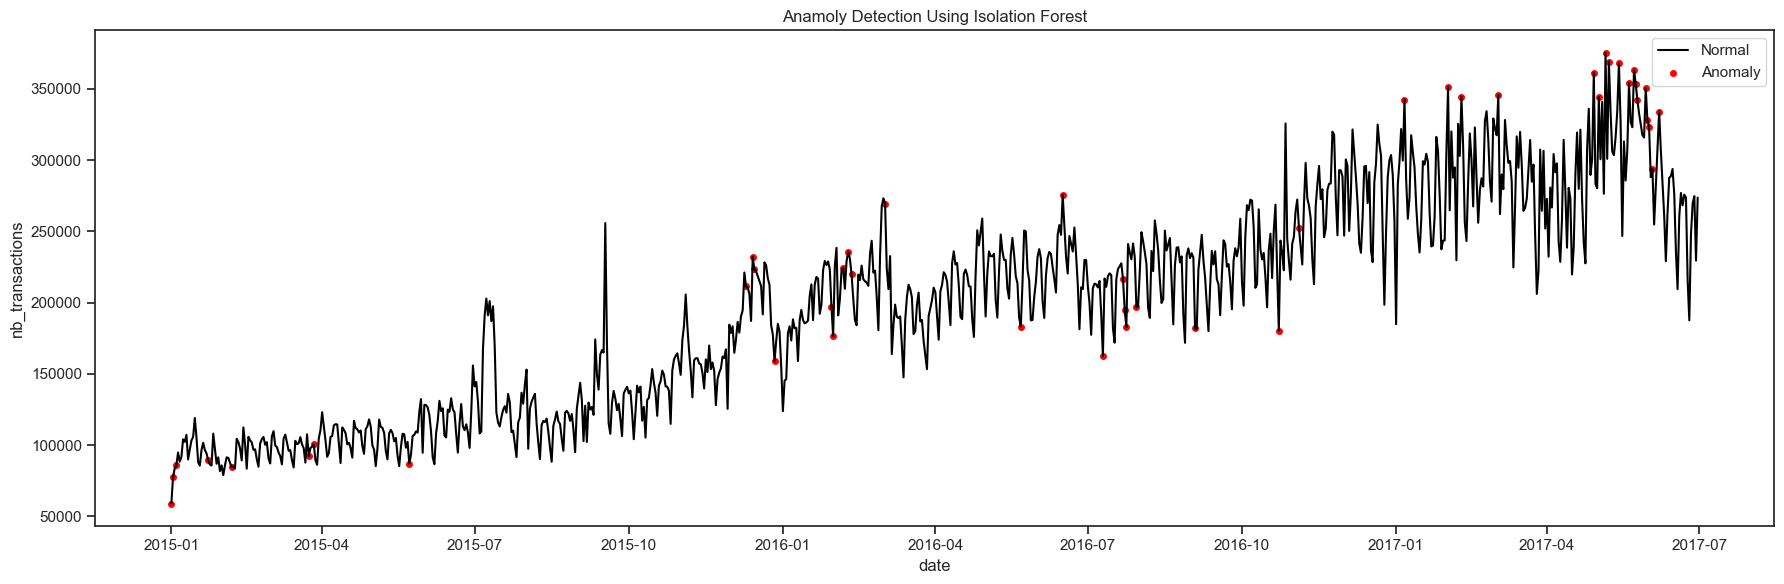

In [14]:
fig, ax = plt.subplots(figsize=(18,6))

a = global_data.loc[global_data['anomaly_IsolationForest'] == 1]
ax.plot('date', 'nb_transactions', data=global_data, color='black', label = 'Normal', linewidth=1.5)
ax.scatter('date', 'nb_transactions', data=a, color='red', label = 'Anomaly', s=16)
plt.legend()
plt.title('Anamoly Detection Using Isolation Forest')
plt.xlabel('date')
plt.ylabel('nb_transactions')
plt.show();

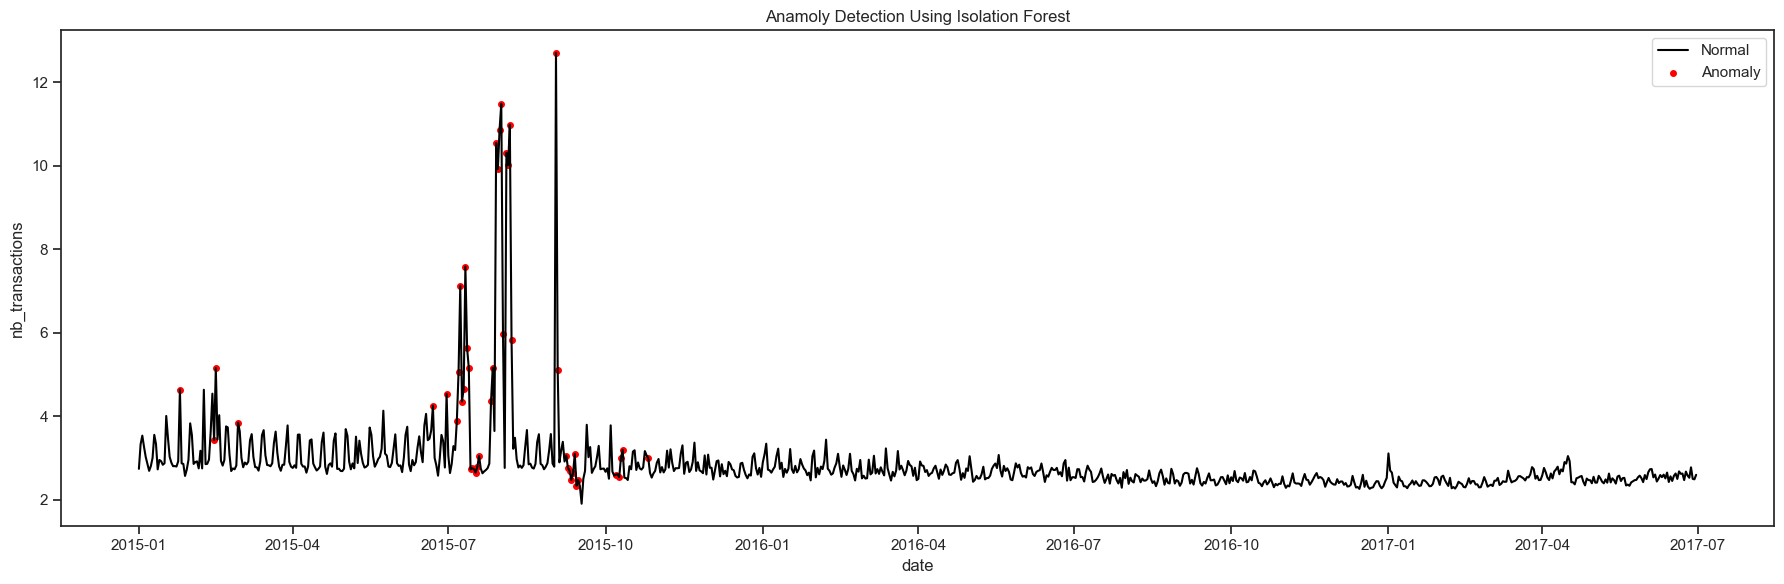

In [83]:
fig, ax = plt.subplots(figsize=(18,6))

a = global_data.loc[global_data['anomaly_IsolationForest'] == 1]
ax.plot('date', 'mean_nb_outputs', data=global_data, color='black', label = 'Normal', linewidth=1.5)
ax.scatter('date', 'mean_nb_outputs', data=a, color='red', label = 'Anomaly', s=16)
plt.legend()
plt.title('Anamoly Detection Using Isolation Forest')
plt.xlabel('date')
plt.ylabel('nb_transactions')
plt.show();

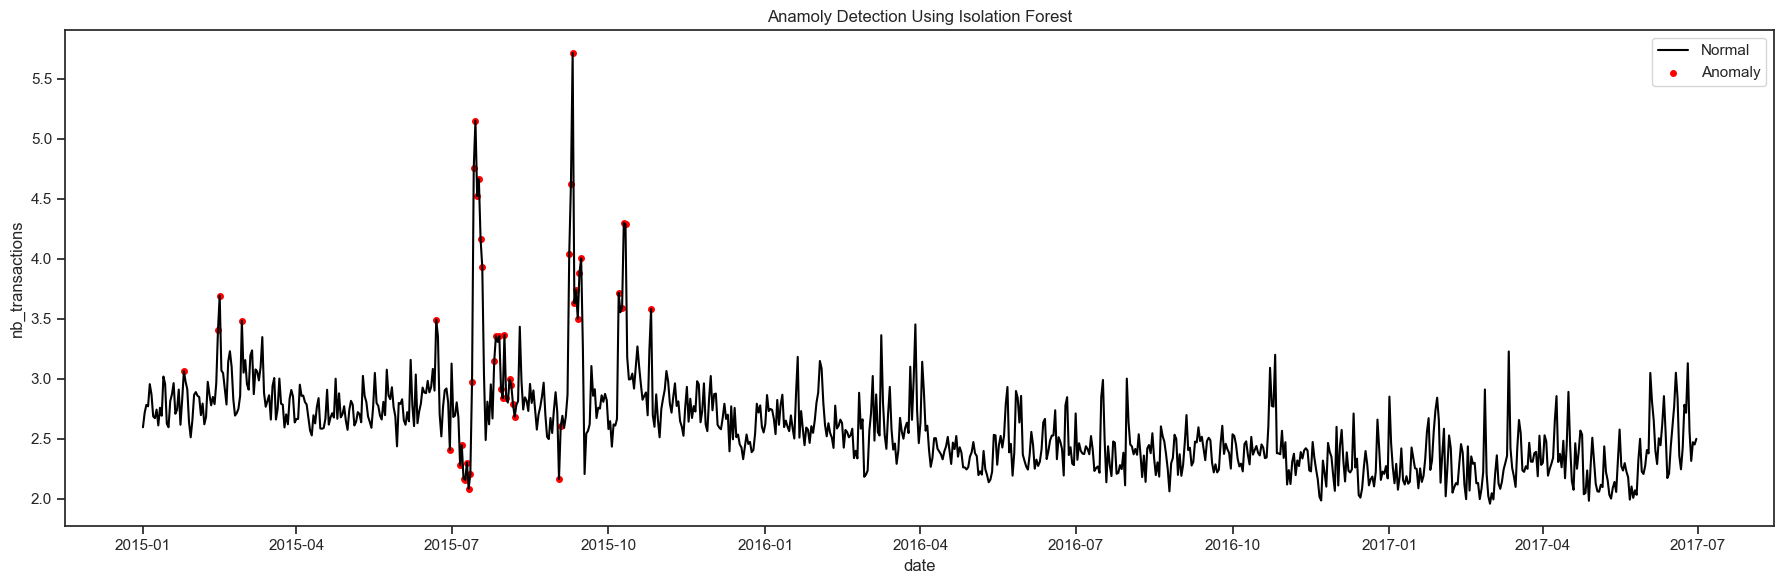

In [84]:
fig, ax = plt.subplots(figsize=(18,6))

a = global_data.loc[global_data['anomaly_IsolationForest'] == 1]
ax.plot('date', 'mean_nb_inputs', data=global_data, color='black', label = 'Normal', linewidth=1.5)
ax.scatter('date', 'mean_nb_inputs', data=a, color='red', label = 'Anomaly', s=16)
plt.legend()
plt.title('Anamoly Detection Using Isolation Forest')
plt.xlabel('date')
plt.ylabel('nb_transactions')
plt.show();

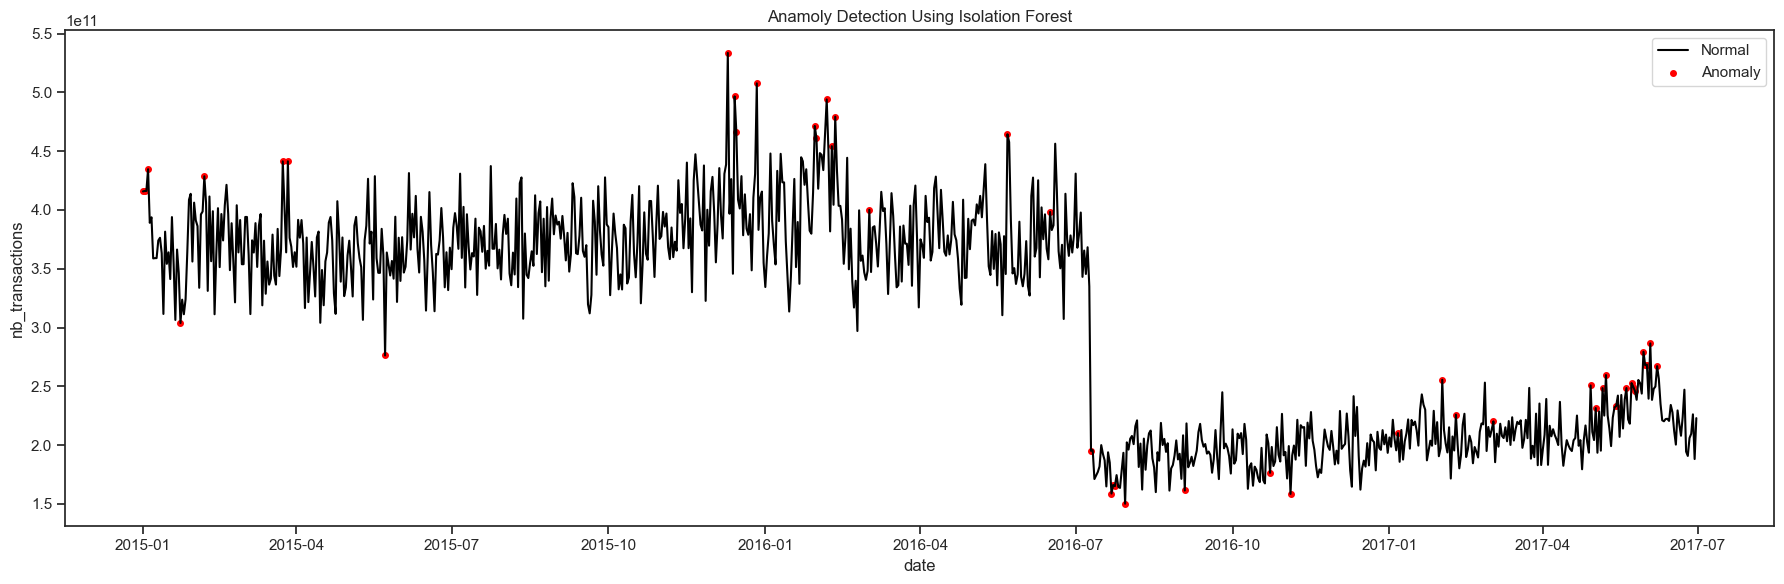

In [15]:
fig, ax = plt.subplots(figsize=(18,6))

a = global_data.loc[global_data['anomaly_IsolationForest'] == 1]
ax.plot('date', 'total_mining_satoshi', data=global_data, color='black', label = 'Normal', linewidth=1.5)
ax.scatter('date', 'total_mining_satoshi', data=a, color='red', label = 'Anomaly', s=16)
plt.legend()
plt.title('Anamoly Detection Using Isolation Forest')
plt.xlabel('date')
plt.ylabel('nb_transactions')
plt.show();

## KMeans


Essayons maitenant un autre algorithme de detection d'anomalies

In [85]:
def pca_results(good_data, pca):
    # Dimension indexing
    dimensions = dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]

    # PCA components
    components = pd.DataFrame(np.round(pca.components_, 4), columns = good_data.keys())
    components.index = dimensions

    # PCA explained variance
    ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
    variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
    variance_ratios.index = dimensions

    # Create a bar plot visualization
    fig, ax = plt.subplots(figsize = (10,10))

    # Plot the feature weights as a function of the components
    components.plot(ax = ax, kind = 'bar');
    ax.set_ylabel("Feature Weights")
    ax.set_xticklabels(dimensions, rotation=0)


    # Display the explained variance ratios
    for i, ev in enumerate(pca.explained_variance_ratio_):
        ax.text(i-0.40, ax.get_ylim()[1] + 0.05, "Explained Variance\n %.4f"%(ev))

    # Return a concatenated DataFrame
    return pd.concat([variance_ratios, components], axis = 1)

c:\Users\aquar\anaconda3\envs\big_data\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\aquar\anaconda3\envs\big_data\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\Users\aquar\anaconda3\envs\big_data\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\aquar\anaconda3\envs\big_data\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than avai

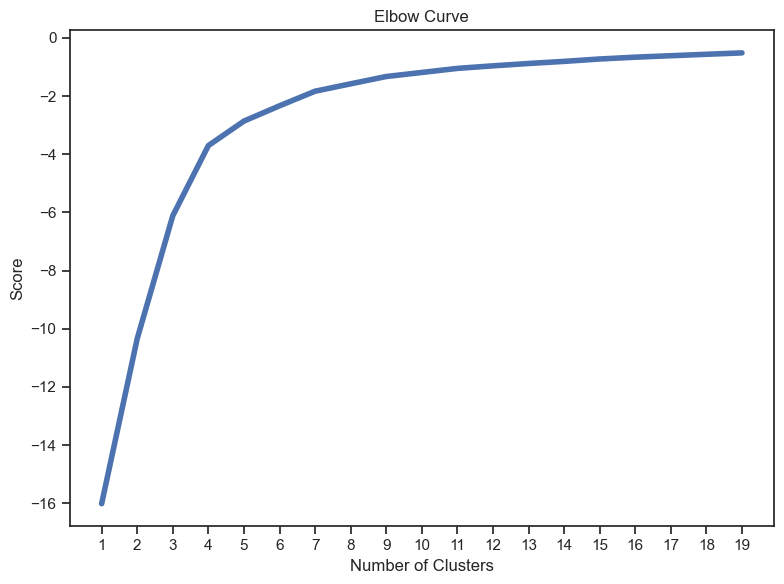

In [86]:
data_ = data.copy() # make a copy of data with two already selected features
data_ = data_.reset_index(drop=True)

data_[:] = MinMaxScaler().fit_transform(data_[:])
pca = PCA(n_components=2) # we have selected 2 components in PCA for simplicity
pca.fit(data_)
reduced_data = pca.transform(data_)
reduced_data = pd.DataFrame(reduced_data)

num_clusters = range(1, 20)

kmeans = [KMeans(n_clusters=i, random_state=135).fit(reduced_data) for i in num_clusters]
scores = [kmeans[i].score(reduced_data) for i in range(len(kmeans))]

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(num_clusters, scores, linewidth = 4)
plt.xticks(num_clusters)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show();



The above elbow-curve helps to determine the number of clusters for the K-means algorithm. The most drastic change recorded in the elbow-curve at 2 or 3 or 4 number of clusters. So let's which one of them is better for our case.

Explained Variance       0       1
Dimension 1              0.8158 -0.7183  0.6957
Dimension 2              0.1842  0.6957  0.7183

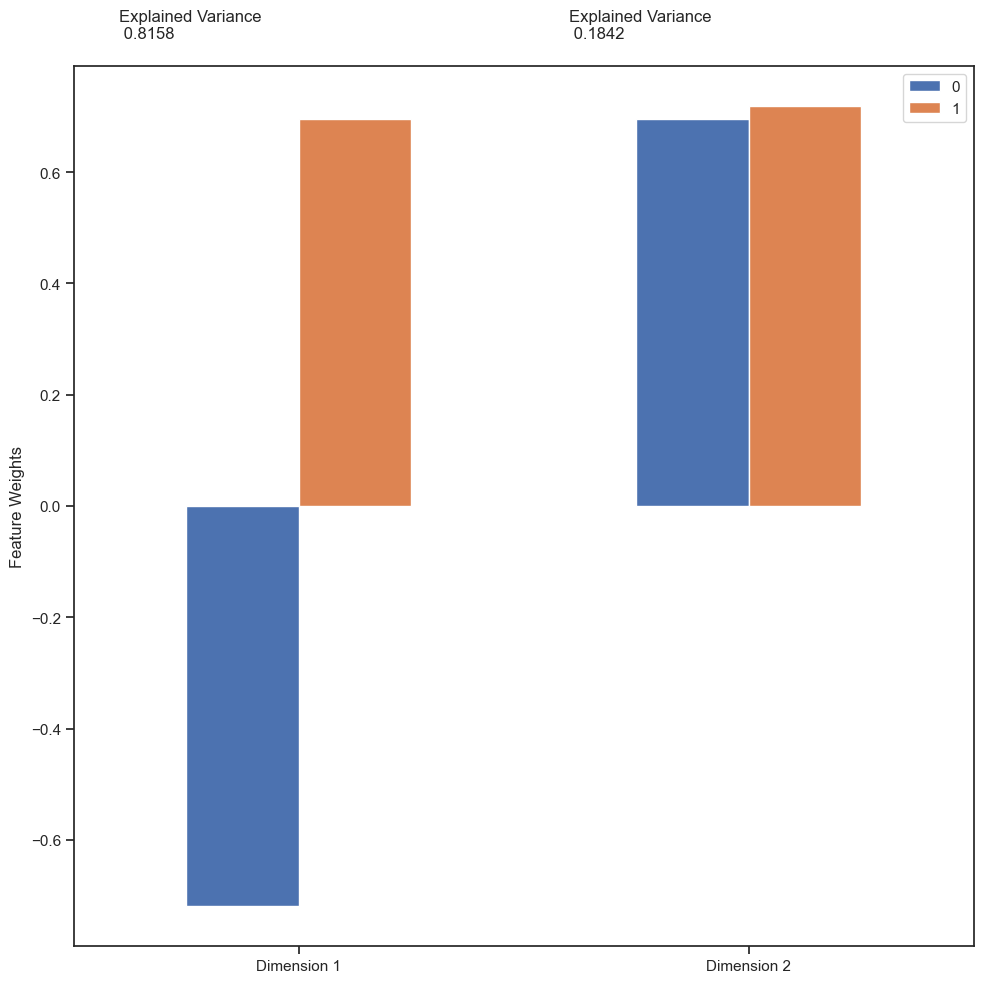

In [18]:
correlations = pd.DataFrame(data=data_).corr()
pca_results(correlations, pca)

In [19]:
#Choosing the three clusters based on the elbow curve
best_num_cluster = 2
km__ = KMeans(n_clusters=best_num_cluster, random_state=135)
km__.fit(reduced_data)
km__.predict(reduced_data)
labels__1 = km__.labels_

#Choosing the four clusters based on the elbow curve
best_num_cluster = 3
km = KMeans(n_clusters=best_num_cluster, random_state=135)
km.fit(reduced_data)
km.predict(reduced_data)
labels = km.labels_

#Choosing the five clusters based on the elbow curve
best_num_cluster = 4
km_ = KMeans(n_clusters=best_num_cluster, random_state=135)
km_.fit(reduced_data)
km_.predict(reduced_data)
labels_1 = km_.labels_

c:\Users\aquar\anaconda3\envs\big_data\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\aquar\anaconda3\envs\big_data\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\Users\aquar\anaconda3\envs\big_data\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\aquar\anaconda3\envs\big_data\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than avai

C:\Users\aquar\AppData\Local\Temp\ipykernel_16340\2437900603.py:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  c=labels__1.astype(np.float), edgecolor="k", s=16)


Text(0.5, 1.0, 'Clusters based on K means: 2 clusters')

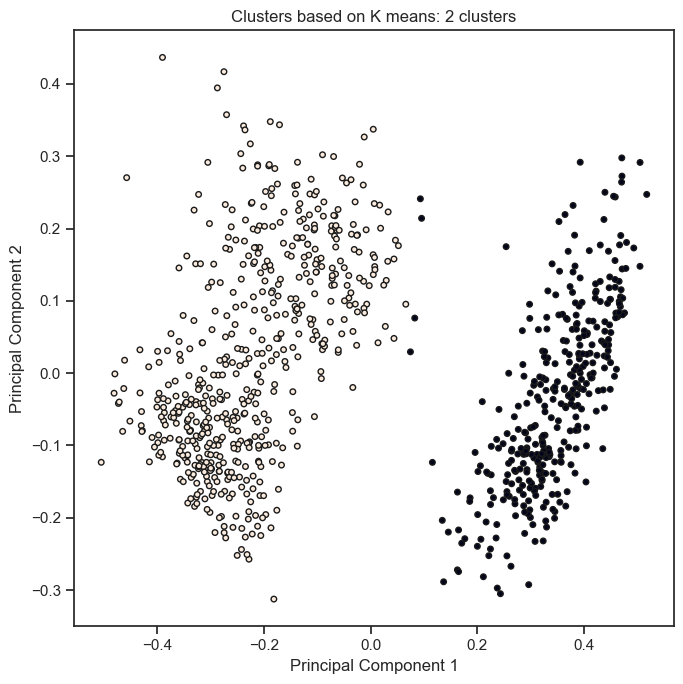

In [20]:
#Plootting based on 2 cluster
fig = plt.figure(1, figsize=(7,7))
plt.scatter(reduced_data.iloc[:,0], reduced_data.iloc[:,1], 
            c=labels__1.astype(np.float), edgecolor="k", s=16)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Clusters based on K means: 2 clusters')

C:\Users\aquar\AppData\Local\Temp\ipykernel_16340\3715196521.py:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  c=labels.astype(np.float), edgecolor="k", s=16)


Text(0.5, 1.0, 'Clusters based on K means: 3 clusters')

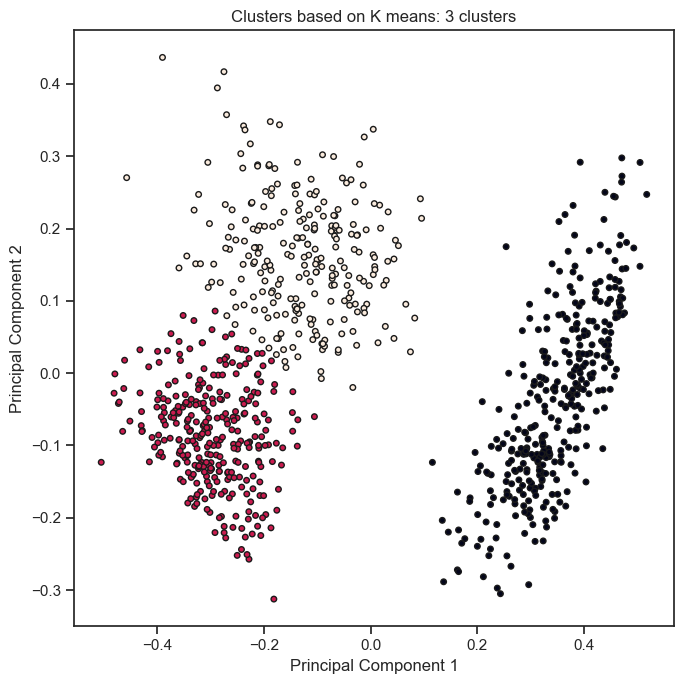

In [21]:
#Plotting based on 3 cluster
fig = plt.figure(1, figsize=(7,7))
plt.scatter(reduced_data.iloc[:,0], reduced_data.iloc[:,1], 
            c=labels.astype(np.float), edgecolor="k", s=16)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Clusters based on K means: 3 clusters')

C:\Users\aquar\AppData\Local\Temp\ipykernel_16340\3813117482.py:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  c=labels_1.astype(np.float), edgecolor="k", s=16)


Text(0.5, 1.0, 'Clusters based on K means: 4 clusters')

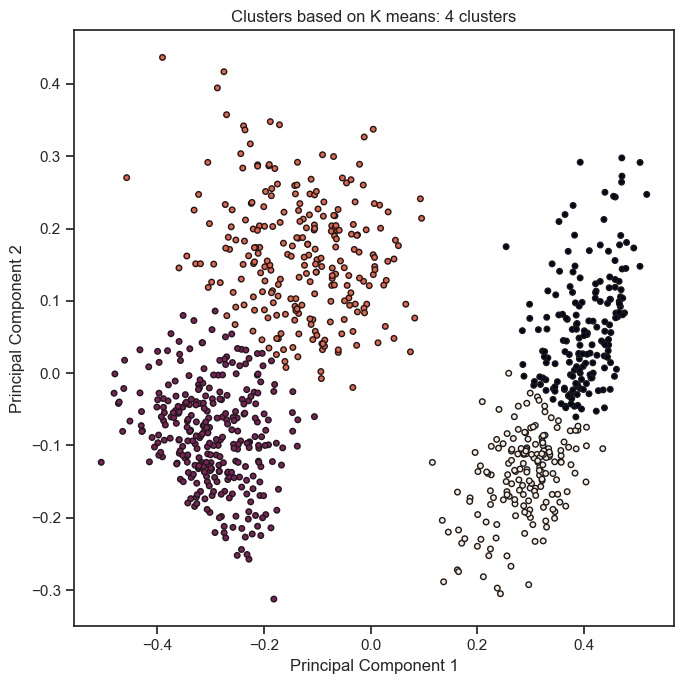

In [22]:
#Plotting based on 4 cluster
fig = plt.figure(1, figsize=(7,7))
plt.scatter(reduced_data.iloc[:,0], reduced_data.iloc[:,1], 
            c=labels_1.astype(np.float), edgecolor="k", s=16)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Clusters based on K means: 4 clusters')

In [23]:
best_num_cluster = 4
reduced_data.loc[0]
mod = kmeans[best_num_cluster-1]
mod.cluster_centers_

array([[ 0.40019393,  0.06199788],
       [-0.29590492, -0.08644724],
       [-0.12849291,  0.16174543],
       [ 0.28865247, -0.14210714]])

In [24]:
reduced_data['Principal Component 1'] = reduced_data[0]
reduced_data['Principal Component 2'] = reduced_data[1]
reduced_data.drop(columns = [0, 1], inplace=True)
reduced_data.head()

Principal Component 1  Principal Component 2
0              -0.504520              -0.123329
1              -0.464381              -0.080542
2              -0.450803              -0.066386
3              -0.480446              -0.027779
4              -0.375385              -0.090064

Text(0.5, 1.0, 'Anomaly prediction using KMeans: Red represents Anomaly')

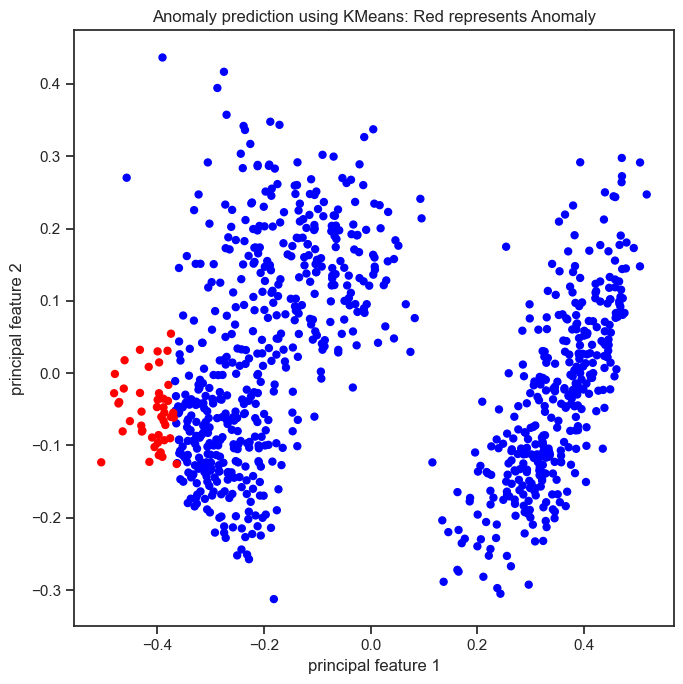

In [45]:
def getDistanceByPoint(data, model):
    distance = []
    for i in range(0,len(data)):
        Xa = np.array(data.loc[i])
        Xb = model.cluster_centers_[model.labels_[i]-1]
        distance.append(np.linalg.norm(Xa-Xb))
    return distance

best_num_cluster = 4
outliers_fraction = 0.05
# find the distance between each point and its nearest centroid. The largest distances will be consdiered anomalies
distance = getDistanceByPoint(reduced_data, kmeans[2])
distance = pd.Series(distance)
number_of_outliers = int(outliers_fraction*len(distance))
threshold = distance.nlargest(number_of_outliers).min()


# anomaly_kmeans contain the anomaly result of the above method  (0:normal, 1:anomaly) 
global_data['anomaly_kmeans'] = (distance >= threshold).astype(int)

# visualisation of anomaly with cluster view
#fig, ax = plt.subplots(figsize=(10,6))
colors = {0:'blue', 1:'red'}
#colors = {1:'#f70505', 0:'#0a48f5'}
plt.figure(figsize=(7,7))
plt.scatter(reduced_data.iloc[:,0], reduced_data.iloc[:,1], 
            c=global_data["anomaly_kmeans"].apply(lambda x: colors[x]), s=25)
plt.xlabel('principal feature 1')
plt.ylabel('principal feature 2')
plt.title('Anomaly prediction using KMeans: Red represents Anomaly')
#plt.savefig('KMeans_anomaly.png', dpi=1000)

In [46]:
best_num_cluster

4

In [47]:
global_data['anomaly_kmeans'].value_counts()

0    867
1     45
Name: anomaly_kmeans, dtype: int64

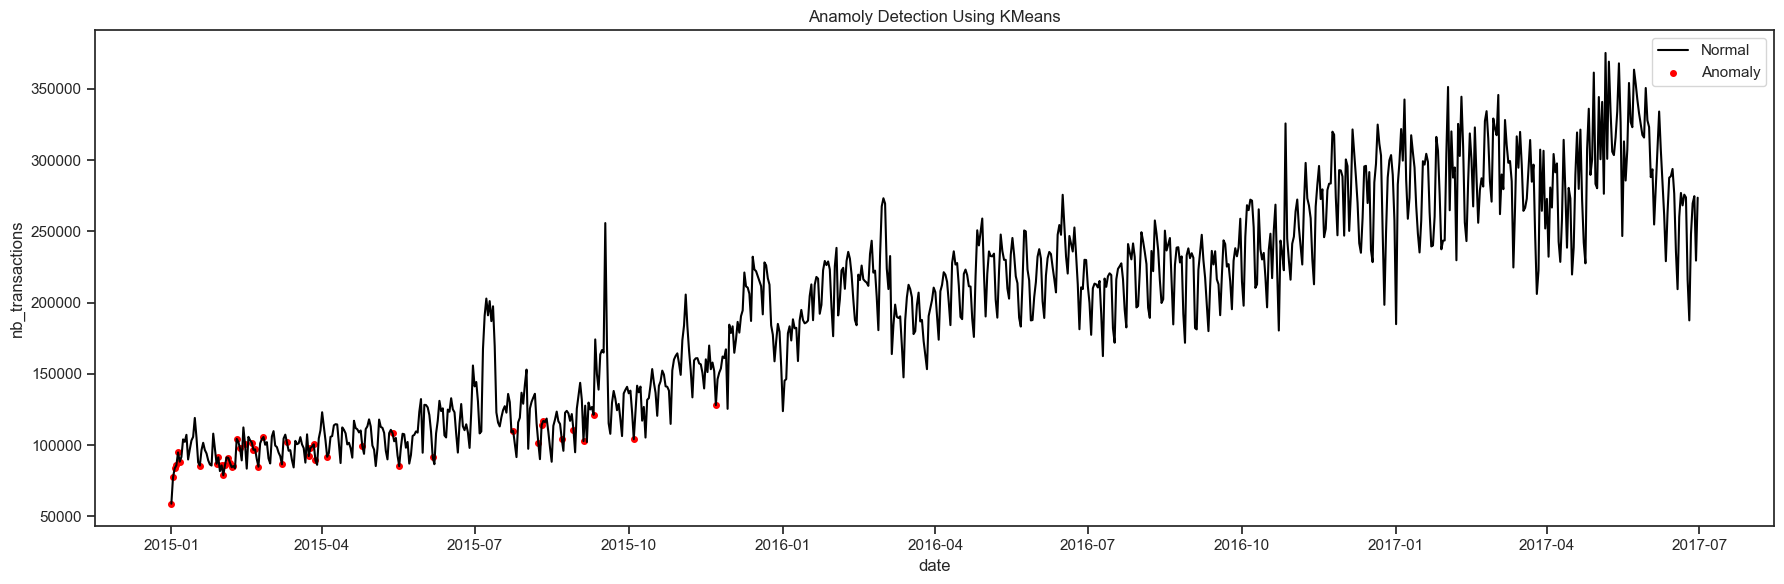

In [48]:
fig, ax = plt.subplots(figsize=(18,6))

a = global_data.loc[global_data['anomaly_kmeans'] == 1]
ax.plot('date', 'nb_transactions', data=global_data, color='black', label = 'Normal', linewidth=1.5)
ax.scatter('date', 'nb_transactions', data=a, color='red', label = 'Anomaly', s=16)
plt.legend()
plt.title('Anamoly Detection Using KMeans')
plt.xlabel('date')
plt.ylabel('nb_transactions')
plt.show();